In [108]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
from matplotlib import pyplot as plt
from scipy.stats import spearmanr
import optuna
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import root_mean_squared_error

In [2]:
import xgboost as xgb
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor

# Data preprocessing

Separate the dataset according to the country

In [3]:
X_train = pd.read_csv("C:/Users/HaoranXIONG/Desktop/Ensemble Learning/data/X_train_NHkHMNU.csv")
Y_train = pd.read_csv("C:/Users/HaoranXIONG/Desktop/Ensemble Learning/data/y_train_ZAN5mwg.csv")
X_test = pd.read_csv("C:/Users/HaoranXIONG/Desktop/Ensemble Learning/data/X_test_final.csv")
Y_test = pd.read_csv("C:/Users/HaoranXIONG/Desktop/Ensemble Learning/data/y_test_random_final.csv")

In [4]:
X_train.head()

,ID,DAY_ID,COUNTRY,DE_CONSUMPTION,FR_CONSUMPTION,DE_FR_EXCHANGE,FR_DE_EXCHANGE,DE_NET_EXPORT,FR_NET_EXPORT,DE_NET_IMPORT,...,FR_RESIDUAL_LOAD,DE_RAIN,FR_RAIN,DE_WIND,FR_WIND,DE_TEMP,FR_TEMP,GAS_RET,COAL_RET,CARBON_RET
0,1054,206,FR,0.210099,-0.427458,-0.606523,0.606523,NaN,0.692860,NaN,...,-0.444661,-0.172680,-0.556356,-0.790823,-0.283160,-1.069070,-0.063404,0.339041,0.124552,-0.002445
1,2049,501,FR,-0.022399,-1.003452,-0.022063,0.022063,-0.573520,-1.130838,0.573520,...,-1.183194,-1.240300,-0.770457,1.522331,0.828412,0.437419,1.831241,-0.659091,0.047114,-0.490365
2,1924,687,FR,1.395035,1.978665,1.021305,-1.021305,-0.622021,-1.682587,0.622021,...,1.947273,-0.480700,-0.313338,0.431134,0.487608,0.684884,0.114836,0.535974,0.743338,0.204952
3,297,720,DE,-0.983324,-0.849198,-0.839586,0.839586,-0.270870,0.563230,0.270870,...,-0.976974,-1.114838,-0.507570,-0.499409,-0.236249,0.350938,-0.417514,0.911652,-0.296168,1.073948
4,1101,818,FR,0.143807,-0.617038,-0.924990,0.924990,NaN,0.990324,NaN,...,-0.526267,-0.541465,-0.424550,-1.088158,-1.011560,0.614338,0.729495,0.245109,1.526606,2.614378


In [5]:
Y_train.head()

,ID,TARGET
0,1054,0.028313
1,2049,-0.112516
2,1924,-0.180840
3,297,-0.260356
4,1101,-0.071733


In [6]:
null_counts_per_column = X_train.isnull().sum()

print(null_counts_per_column)


ID                    0
DAY_ID                0
COUNTRY               0
DE_CONSUMPTION        0
FR_CONSUMPTION        0
DE_FR_EXCHANGE       25
FR_DE_EXCHANGE       25
DE_NET_EXPORT       124
FR_NET_EXPORT        70
DE_NET_IMPORT       124
FR_NET_IMPORT        70
DE_GAS                0
FR_GAS                0
DE_COAL               0
FR_COAL               0
DE_HYDRO              0
FR_HYDRO              0
DE_NUCLEAR            0
FR_NUCLEAR            0
DE_SOLAR              0
FR_SOLAR              0
DE_WINDPOW            0
FR_WINDPOW            0
DE_LIGNITE            0
DE_RESIDUAL_LOAD      0
FR_RESIDUAL_LOAD      0
DE_RAIN              94
FR_RAIN              94
DE_WIND              94
FR_WIND              94
DE_TEMP              94
FR_TEMP              94
GAS_RET               0
COAL_RET              0
CARBON_RET            0
dtype: int64


From the distribution of each column, we fill the na value by average in columns:
DE_FR_EXCHANGE
FR_DE_EXCHANGE
DE_TEMP
FR_TEMP

And we will fill the na value by median in columns because of their skewness:
DE_NET_EXPORT
FR_NET_EXPORT
DE_NET_IMPORT
FR_NET_IMPORT
DE_RAIN
FR_RAIN
DE_WIND
FR_WIND

In [7]:
X_train[['DE_FR_EXCHANGE','FR_DE_EXCHANGE','DE_TEMP','FR_TEMP']] = (
    X_train[['DE_FR_EXCHANGE','FR_DE_EXCHANGE','DE_TEMP','FR_TEMP']]).fillna(
    X_train[['DE_FR_EXCHANGE','FR_DE_EXCHANGE','DE_TEMP','FR_TEMP']].mean())

In [8]:
X_train[['DE_NET_EXPORT','FR_NET_EXPORT','DE_NET_IMPORT','FR_NET_IMPORT','DE_RAIN','FR_RAIN','DE_WIND','FR_WIND']]=(
    X_train[['DE_NET_EXPORT','FR_NET_EXPORT','DE_NET_IMPORT','FR_NET_IMPORT','DE_RAIN','FR_RAIN','DE_WIND','FR_WIND']]).fillna(
    X_train[['DE_NET_EXPORT','FR_NET_EXPORT','DE_NET_IMPORT','FR_NET_IMPORT','DE_RAIN','FR_RAIN','DE_WIND','FR_WIND']].median()
)

In [9]:
X_test[['DE_FR_EXCHANGE','FR_DE_EXCHANGE','DE_TEMP','FR_TEMP']] = (
    X_test[['DE_FR_EXCHANGE','FR_DE_EXCHANGE','DE_TEMP','FR_TEMP']]).fillna(
    X_test[['DE_FR_EXCHANGE','FR_DE_EXCHANGE','DE_TEMP','FR_TEMP']].mean())

In [10]:
X_test[['DE_NET_EXPORT','FR_NET_EXPORT','DE_NET_IMPORT','FR_NET_IMPORT','DE_RAIN','FR_RAIN','DE_WIND','FR_WIND']]=(
    X_test[['DE_NET_EXPORT','FR_NET_EXPORT','DE_NET_IMPORT','FR_NET_IMPORT','DE_RAIN','FR_RAIN','DE_WIND','FR_WIND']]).fillna(
    X_test[['DE_NET_EXPORT','FR_NET_EXPORT','DE_NET_IMPORT','FR_NET_IMPORT','DE_RAIN','FR_RAIN','DE_WIND','FR_WIND']].median()
)

In [11]:
null_counts_per_column = X_train.isnull().sum()

print(null_counts_per_column)


ID                  0
DAY_ID              0
COUNTRY             0
DE_CONSUMPTION      0
FR_CONSUMPTION      0
DE_FR_EXCHANGE      0
FR_DE_EXCHANGE      0
DE_NET_EXPORT       0
FR_NET_EXPORT       0
DE_NET_IMPORT       0
FR_NET_IMPORT       0
DE_GAS              0
FR_GAS              0
DE_COAL             0
FR_COAL             0
DE_HYDRO            0
FR_HYDRO            0
DE_NUCLEAR          0
FR_NUCLEAR          0
DE_SOLAR            0
FR_SOLAR            0
DE_WINDPOW          0
FR_WINDPOW          0
DE_LIGNITE          0
DE_RESIDUAL_LOAD    0
FR_RESIDUAL_LOAD    0
DE_RAIN             0
FR_RAIN             0
DE_WIND             0
FR_WIND             0
DE_TEMP             0
FR_TEMP             0
GAS_RET             0
COAL_RET            0
CARBON_RET          0
dtype: int64


In [12]:
null_counts_per_column = X_test.isnull().sum()

print(null_counts_per_column)

ID                  0
DAY_ID              0
COUNTRY             0
DE_CONSUMPTION      0
FR_CONSUMPTION      0
DE_FR_EXCHANGE      0
FR_DE_EXCHANGE      0
DE_NET_EXPORT       0
FR_NET_EXPORT       0
DE_NET_IMPORT       0
FR_NET_IMPORT       0
DE_GAS              0
FR_GAS              0
DE_COAL             0
FR_COAL             0
DE_HYDRO            0
FR_HYDRO            0
DE_NUCLEAR          0
FR_NUCLEAR          0
DE_SOLAR            0
FR_SOLAR            0
DE_WINDPOW          0
FR_WINDPOW          0
DE_LIGNITE          0
DE_RESIDUAL_LOAD    0
FR_RESIDUAL_LOAD    0
DE_RAIN             0
FR_RAIN             0
DE_WIND             0
FR_WIND             0
DE_TEMP             0
FR_TEMP             0
GAS_RET             0
COAL_RET            0
CARBON_RET          0
dtype: int64


So far we clear the na value in the dataframe.

In the data preprocessing part we know that :
Columns 'DE_FR_EXCHANGE' and 'FR_DE_EXCHANGE' have a correlation of -1.
Columns 'DE_NET_EXPORT' and 'DE_NET_IMPORT' have a correlation of -1.
Columns 'FR_NET_EXPORT' and 'FR_NET_IMPORT' have a correlation of -1.

So we are going to drop one of each pair of column

In [13]:
# Select the column to encode
col = ['COUNTRY']
# Create the encoder
encoder = OneHotEncoder()
# Fit the encoder
encoder.fit(X_train[col])
# Transform the column
encoded = encoder.transform(X_train[col]).toarray()
# Create the new columns
for i, category in enumerate(encoder.categories_[0]):
    X_train[category] = encoded[:, i]
# Drop the old column
X_train = X_train.drop(columns=col)

# Print the first 5 rows of the encoded data
print(X_train.iloc[:, -2:])

       DE   FR
0     0.0  1.0
1     0.0  1.0
2     0.0  1.0
3     1.0  0.0
4     0.0  1.0
...   ...  ...
1489  1.0  0.0
1490  0.0  1.0
1491  1.0  0.0
1492  0.0  1.0
1493  1.0  0.0

[1494 rows x 2 columns]


### Normalize the data

In [14]:
# Select the numerical columns to normalize
cols = [col for col in X_train.columns if col not in ['ID', 'DAY_ID', 'FR', 'DE']]
# Normalize the data
X_train[cols] = (X_train[cols] - X_train[cols].mean()) / X_train[cols].std()

### Check for outliers

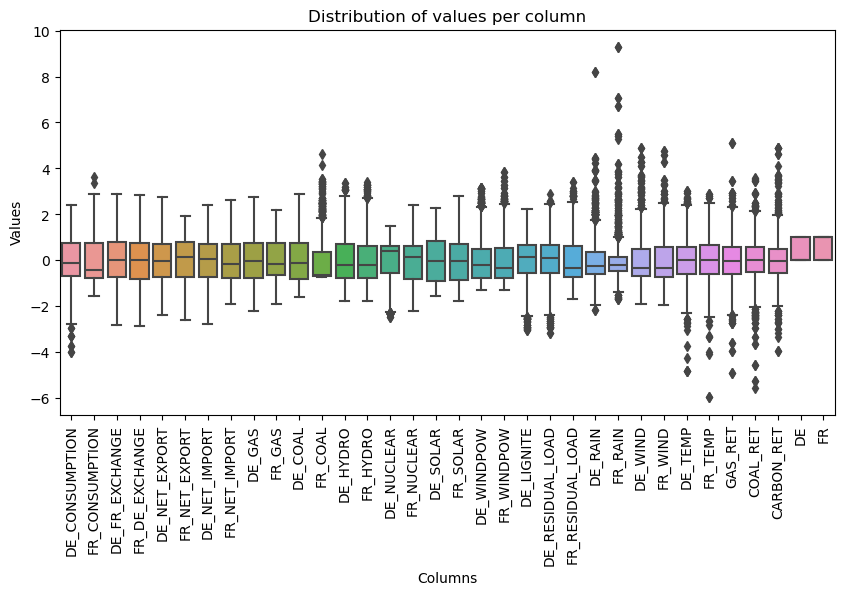

In [15]:
def show_distributions(data):
    # Select the numerical columns to plot
    cols = [col for col in data.columns if col not in ['ID', 'DAY_ID']]
    # Plot the distributions
    plt.figure(figsize=(10, 5))
    sns.boxplot(data=data[cols])
    plt.xticks(rotation=90)
    plt.xlabel('Columns')
    plt.ylabel('Values')
    plt.title('Distribution of values per column')
    plt.show()

show_distributions(X_train)

In [16]:
# Select the numerical columns to check for outliers
cols = [col for col in X_train.columns if col not in ['ID', 'DAY_ID']]
# Calculate the z-scores for each column
z_scores = np.abs((X_train[cols] - X_train[cols].mean()) / X_train[cols].std())
# Define a threshold for the z-score above which a value is considered an outlier
threshold = 2
# Identify the rows containing outliers
outliers = z_scores[(z_scores > threshold).any(axis=1)]
# Remove the rows containing outliers
X_train = X_train[(z_scores <= threshold).all(axis=1)]

Number of rows removed:  843


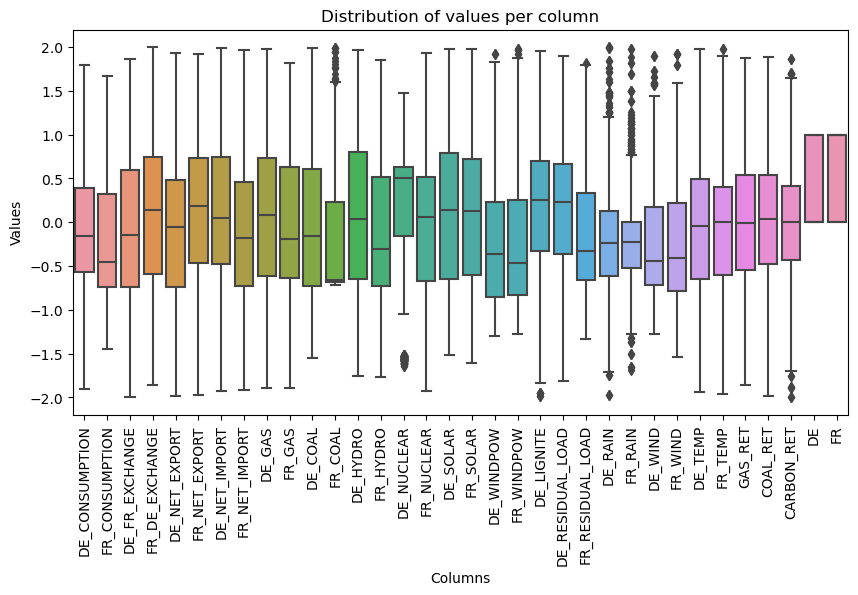

In [17]:
# Print the number of rows removed
print("Number of rows removed: ", len(outliers))
show_distributions(X_train)

In [18]:
# remove the lines from the data_y dataset
Y_train = Y_train[Y_train['ID'].isin(X_train['ID'])]

### Check for colinearity

In [19]:
# Select the numerical columns to check for colinearity
cols = [col for col in X_train.columns if col not in ['ID', 'DAY_ID']]
# Calculate the Pearson correlation coefficient for each pair of columns
corr_matrix = X_train[cols].corr(method='pearson')

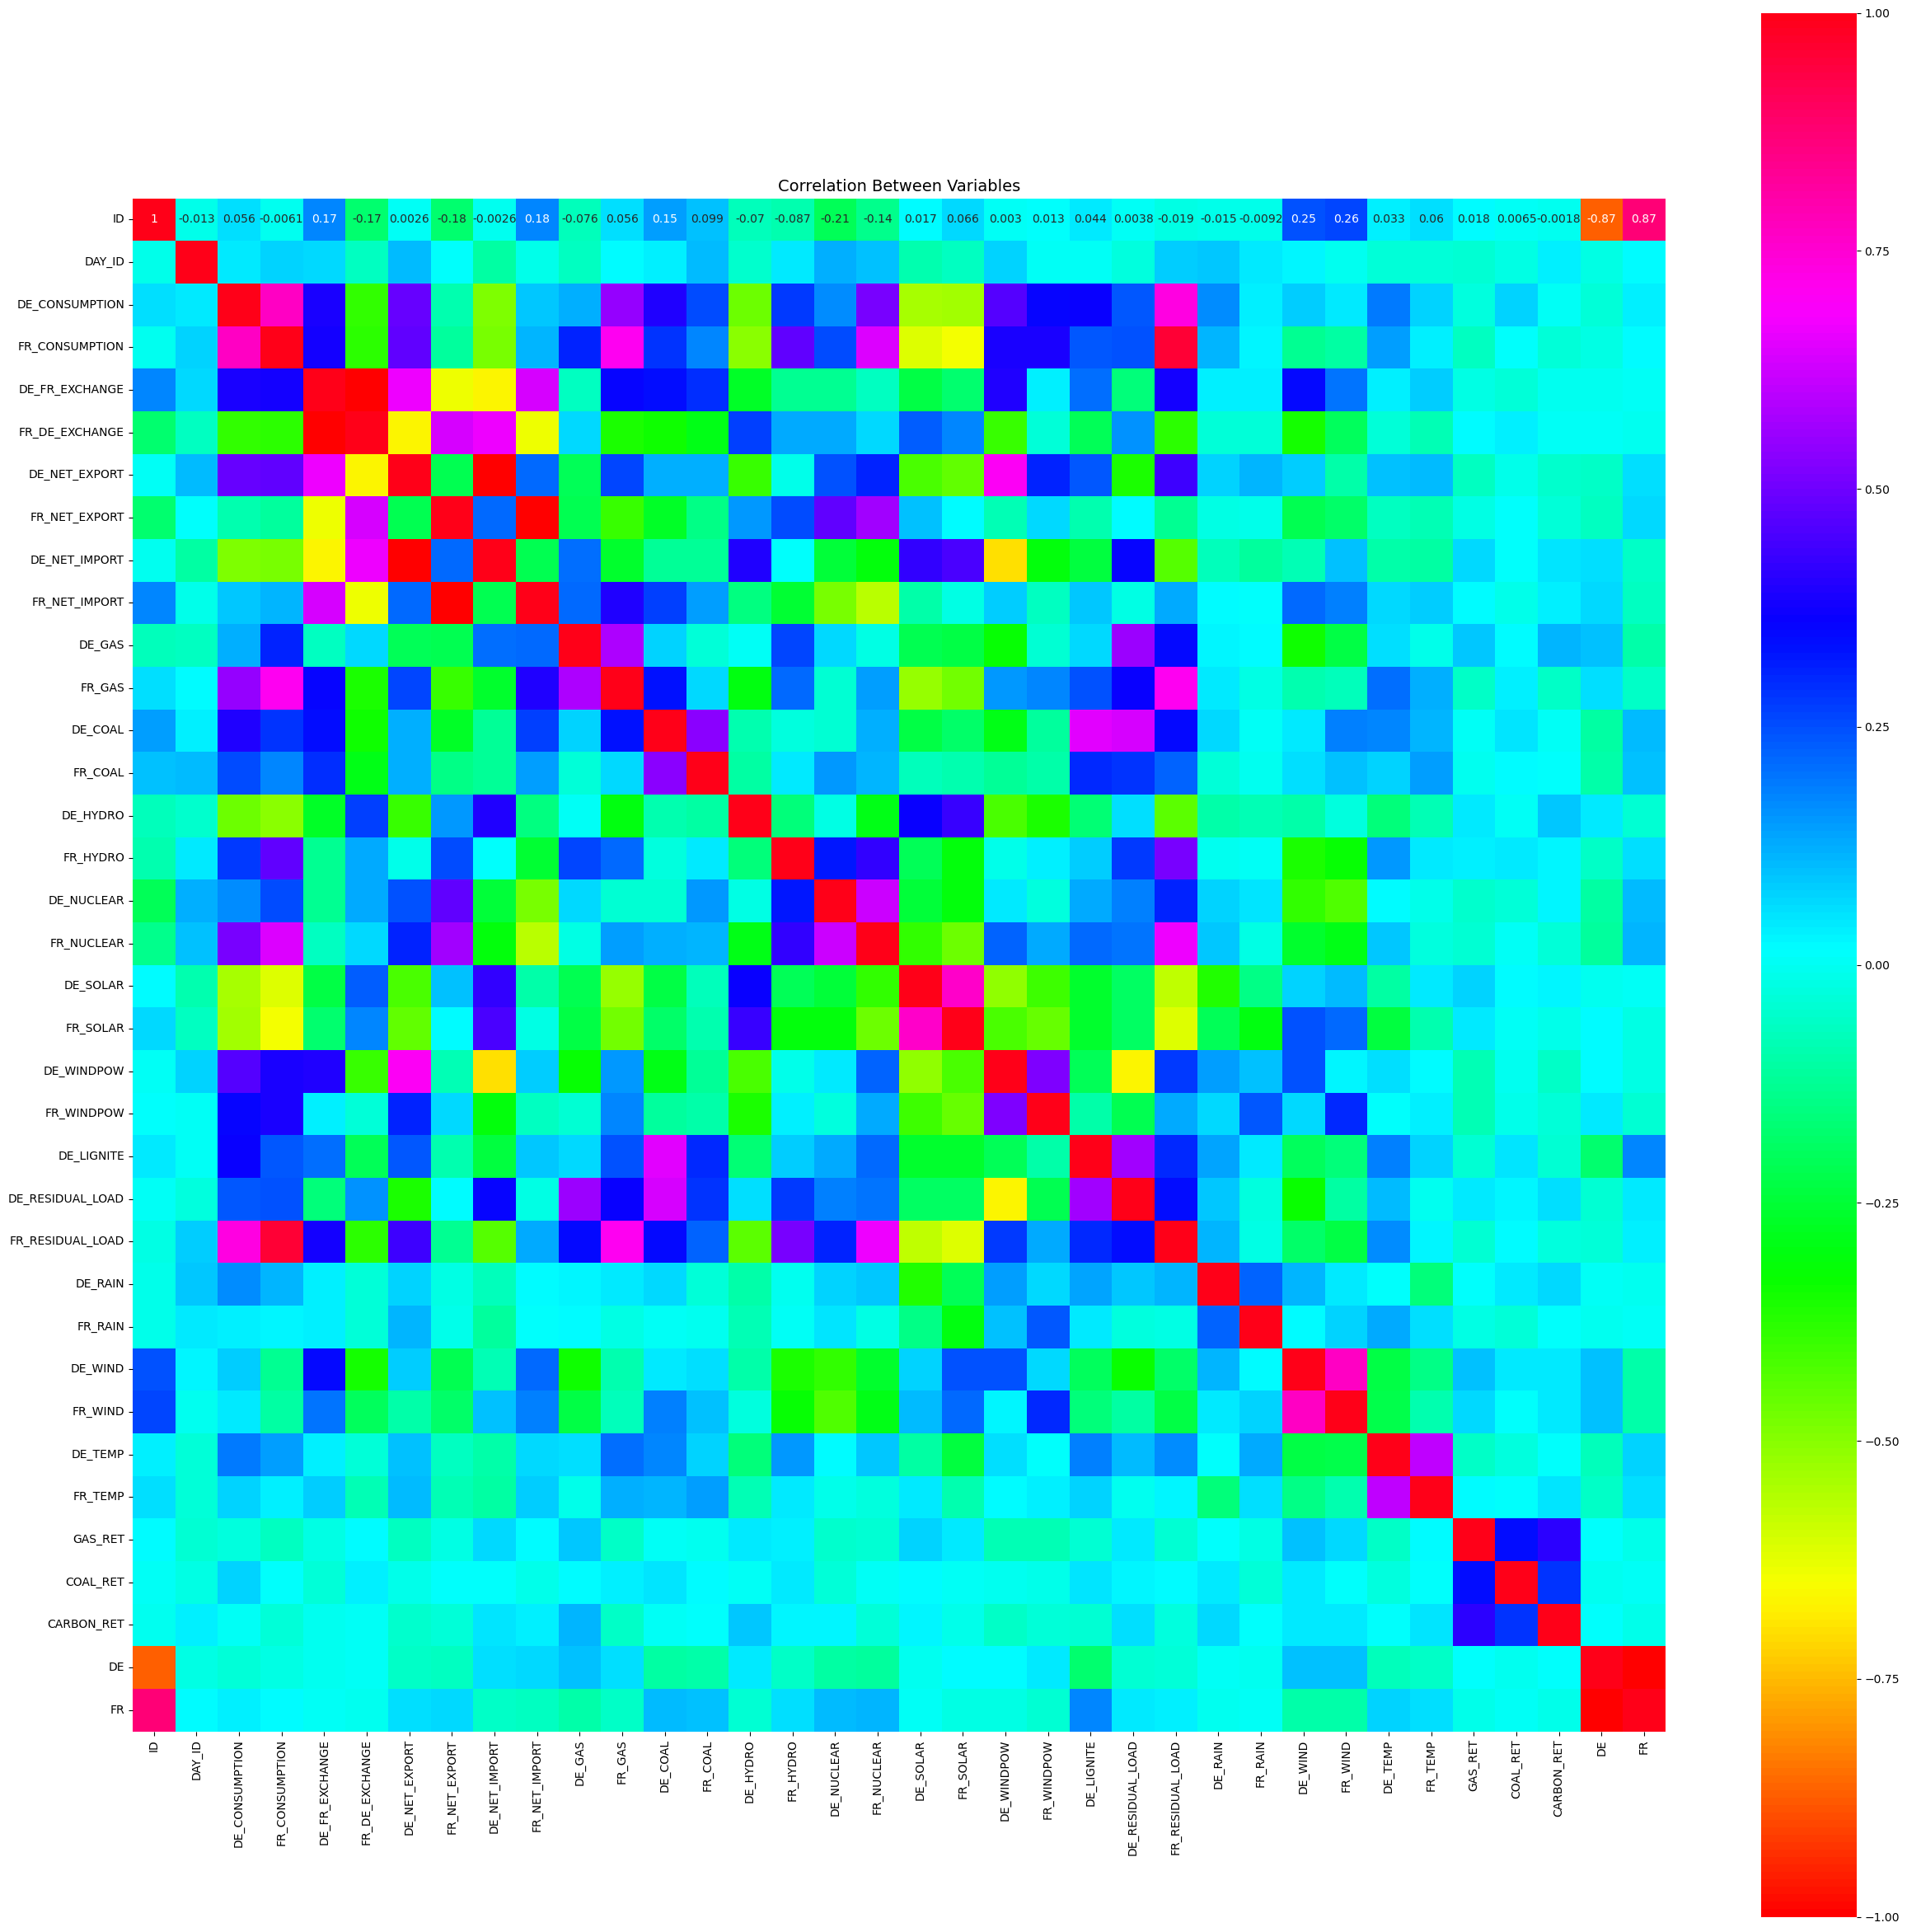

In [20]:
correlation_metrics=X_train.corr()
fig = plt.figure(figsize=(30,30))
sns.heatmap(correlation_metrics,square=True, annot=True, cmap='hsv', vmin=-1, vmax=1)
plt.title('Correlation Between Variables', size=14)
plt.show()

In [21]:
# find the columns to remove
cols_to_remove_1 = []
for i in range(len(cols)):
    for j in range(i + 1, len(cols)):
        if abs(corr_matrix.iloc[i, j]) > 0.8:
            cols_to_remove_1.append(cols[j])

# print the columns to remove
print(cols_to_remove_1)

['FR_RESIDUAL_LOAD', 'FR_DE_EXCHANGE', 'DE_NET_IMPORT', 'FR_NET_IMPORT', 'FR']


In [22]:
# remove the columns
X_train = X_train.drop(cols_to_remove_1, axis=1)

### Find the feature importances

In [23]:
X_train = X_train.drop(columns=['ID','DAY_ID'])

In [24]:
def get_importance_of_variables(data_x, data_y):
    # Instantiate the random forest model
    rf = RandomForestRegressor(n_estimators=100, random_state=42)

    # Train the model
    rf.fit(data_x, data_y['TARGET'])

    # Get the feature importances
    feature_importances = rf.feature_importances_

    # Get the indices of the most important variables
    indices = feature_importances.argsort()[::-1]

    # Get the names of the most important variables
    names = [data_x.columns[i] for i in indices]

    # Create a pandas DataFrame to store the feature importances
    importance_df = pd.DataFrame({'feature': names, 'importance': feature_importances[indices]})

    return importance_df


importance = get_importance_of_variables(X_train, Y_train)

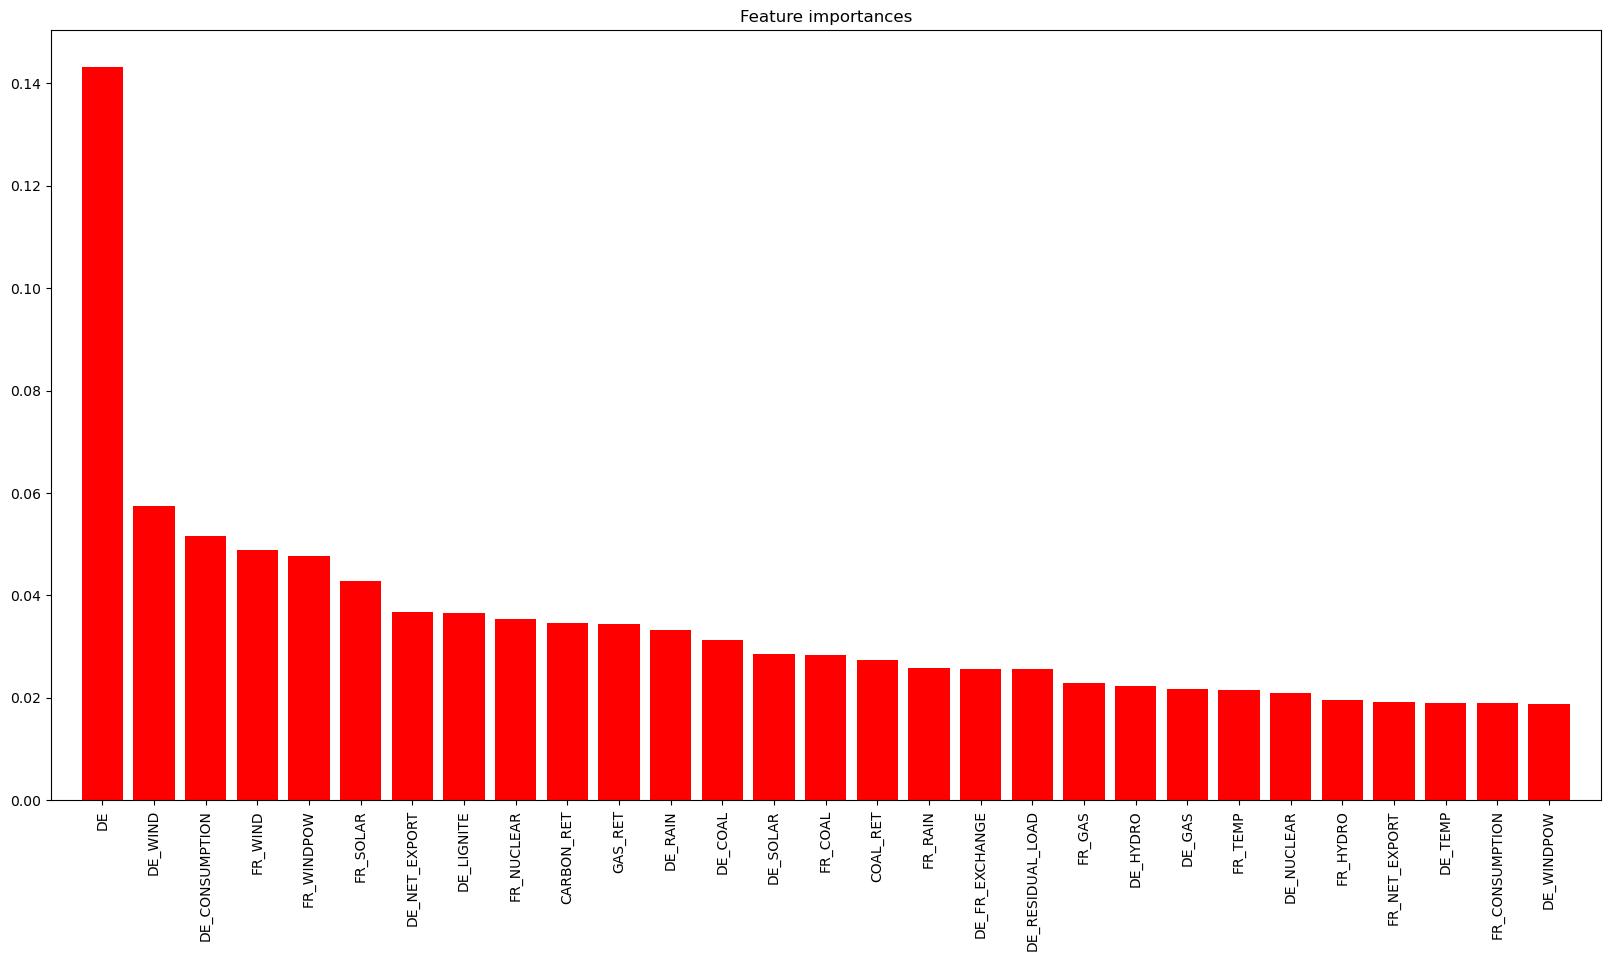

In [25]:
# Plot the feature importances
plt.figure(figsize=(20, 10))
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importance['importance'], color="r", align="center")
plt.xticks(range(X_train.shape[1]), importance['feature'], rotation='vertical')
plt.xlim([-1, X_train.shape[1]])
plt.show()

In [26]:
# Remove the features that have an importance lower than 0.025
cols_to_remove_2 = importance[importance['importance'] < 0.025]['feature'].tolist()
X_train = X_train.drop(cols_to_remove_2, axis=1)

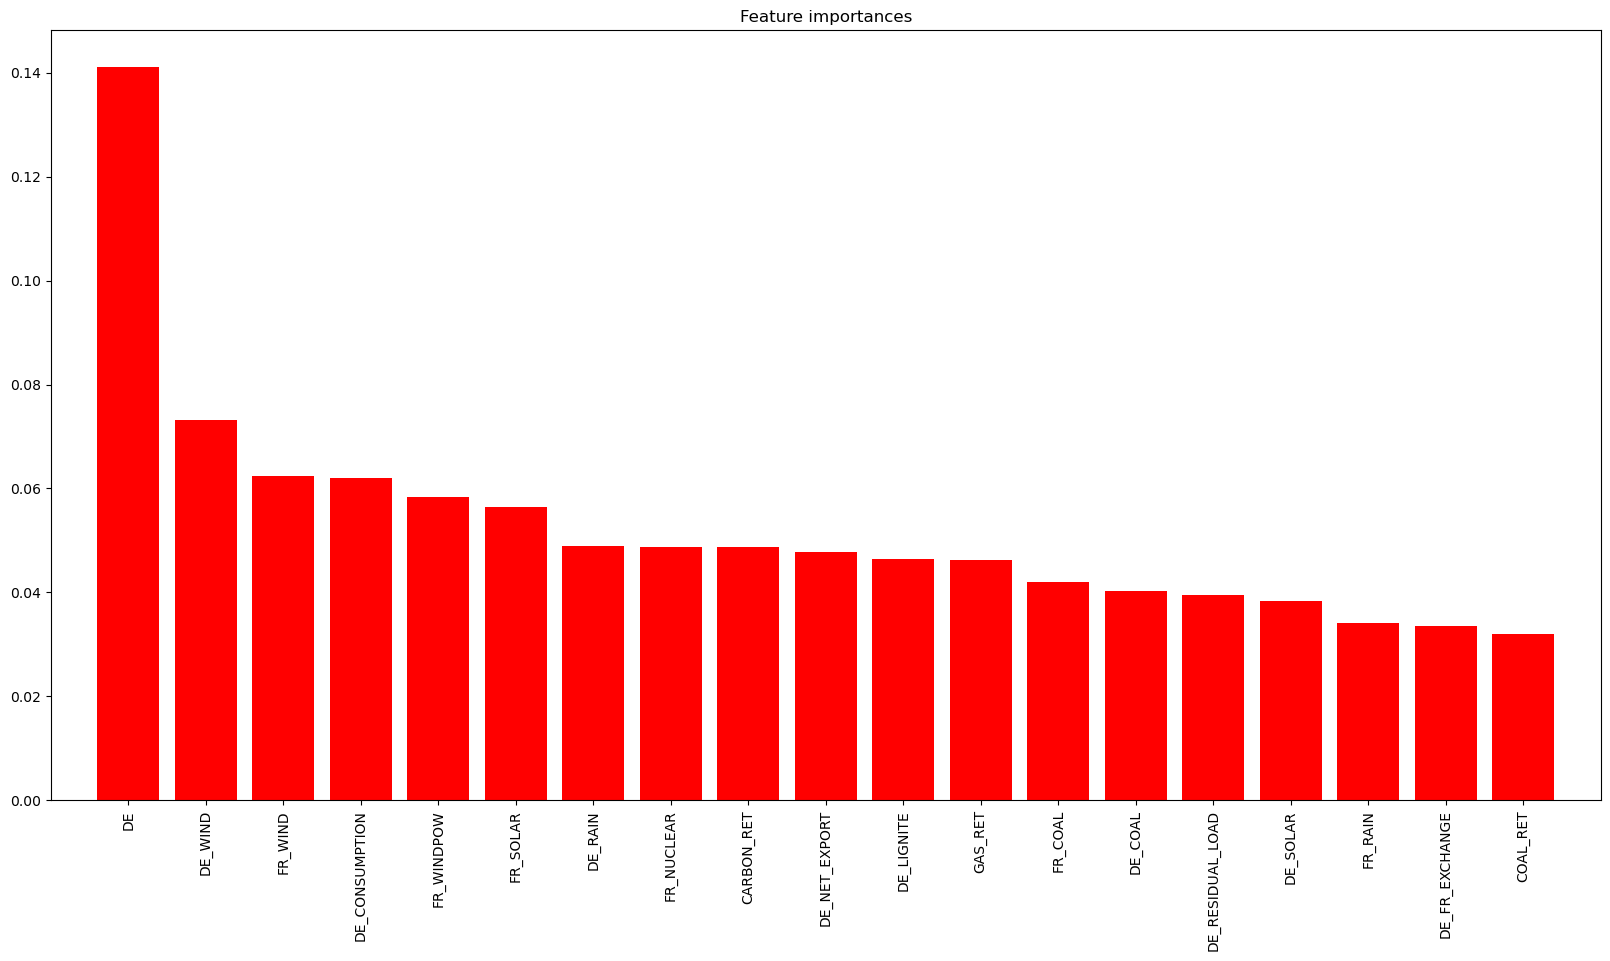

In [27]:
importance = get_importance_of_variables(X_train, Y_train)

# Plot the feature importances
plt.figure(figsize=(20, 10))
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importance['importance'], color="r", align="center")
plt.xticks(range(X_train.shape[1]), importance['feature'], rotation='vertical')
plt.xlim([-1, X_train.shape[1]])
plt.show()

### Find the correlation between features and target

In [28]:
corr_matrix = X_train.corrwith(Y_train['TARGET'], method='pearson')
# sort the correlations
corr_matrix.sort_values(inplace=True)

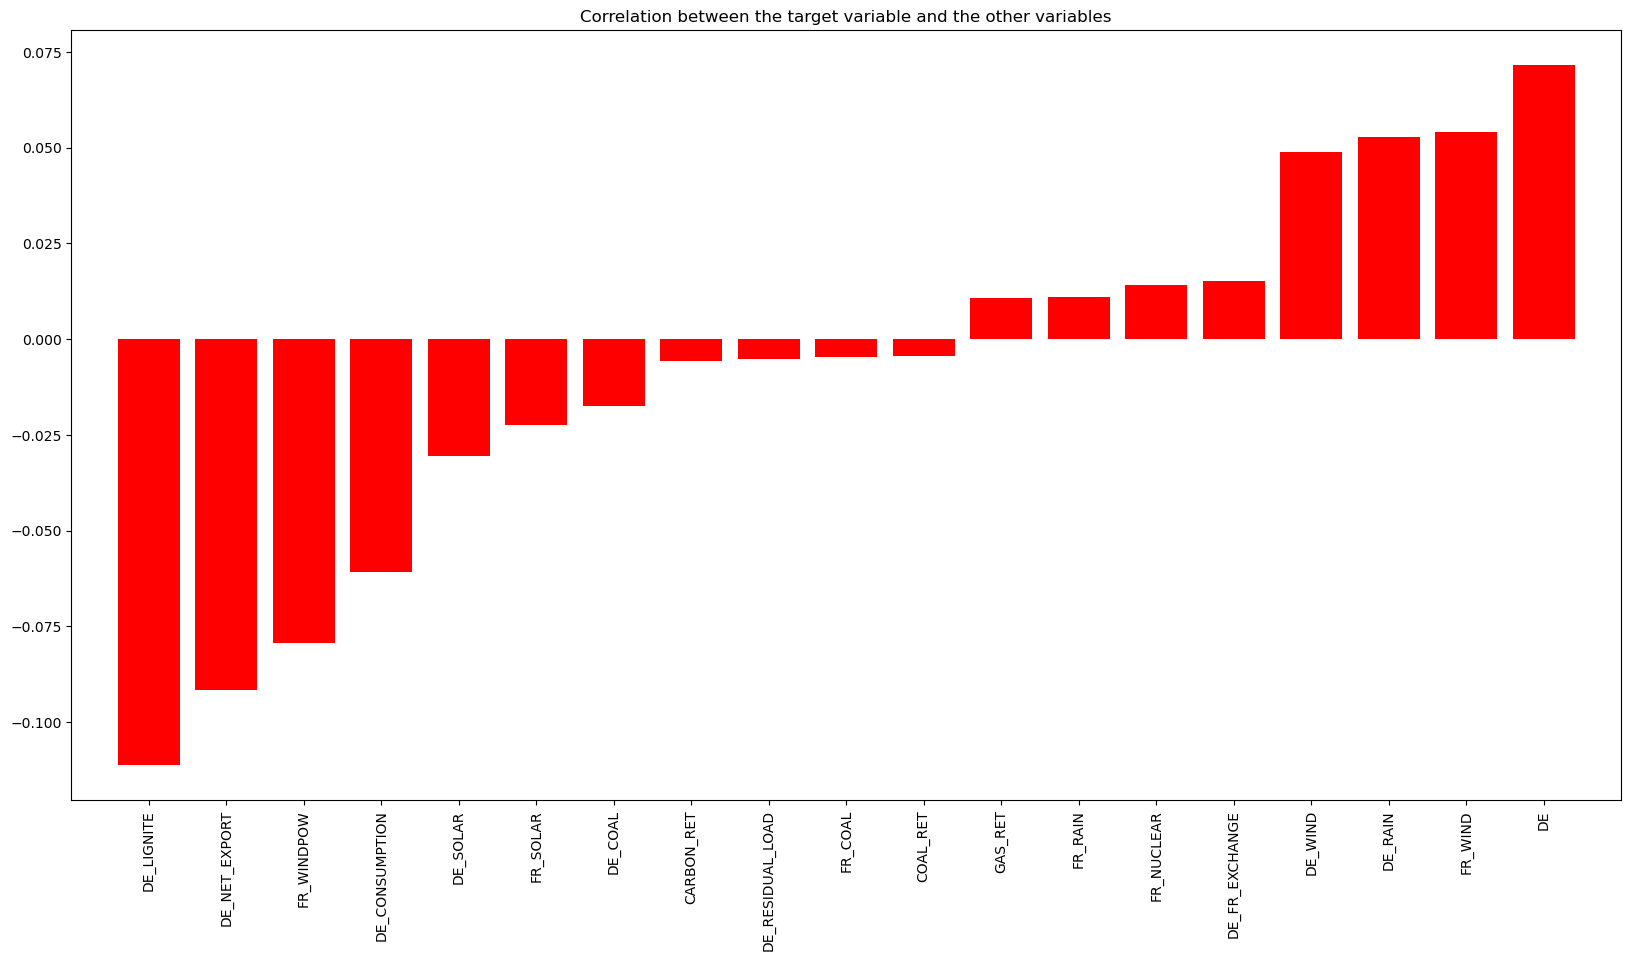

In [29]:
plt.figure(figsize=(20, 10))
plt.title("Correlation between the target variable and the other variables")
plt.bar(range(len(corr_matrix)), corr_matrix, color="r", align="center")
plt.xticks(range(len(corr_matrix)), corr_matrix.index, rotation='vertical')
plt.xlim([-1, len(corr_matrix)])
plt.show()

#### Process the test set

In [30]:
# remove the empty cells
print(X_test.isnull().sum())

ID                  0
DAY_ID              0
COUNTRY             0
DE_CONSUMPTION      0
FR_CONSUMPTION      0
DE_FR_EXCHANGE      0
FR_DE_EXCHANGE      0
DE_NET_EXPORT       0
FR_NET_EXPORT       0
DE_NET_IMPORT       0
FR_NET_IMPORT       0
DE_GAS              0
FR_GAS              0
DE_COAL             0
FR_COAL             0
DE_HYDRO            0
FR_HYDRO            0
DE_NUCLEAR          0
FR_NUCLEAR          0
DE_SOLAR            0
FR_SOLAR            0
DE_WINDPOW          0
FR_WINDPOW          0
DE_LIGNITE          0
DE_RESIDUAL_LOAD    0
FR_RESIDUAL_LOAD    0
DE_RAIN             0
FR_RAIN             0
DE_WIND             0
FR_WIND             0
DE_TEMP             0
FR_TEMP             0
GAS_RET             0
COAL_RET            0
CARBON_RET          0
dtype: int64


In [31]:
# Select the column to encode
col = ['COUNTRY']
# Create the encoder
encoder = OneHotEncoder()
# Fit the encoder
encoder.fit(X_test[col])
# Transform the column
encoded = encoder.transform(X_test[col]).toarray()
# Create the new columns
for i, category in enumerate(encoder.categories_[0]):
    X_test[category] = encoded[:, i]
# Drop the old column
X_test = X_test.drop(columns=col)

# Print the first 5 rows of the encoded data
print(X_test.iloc[:, -2:])

      DE   FR
0    0.0  1.0
1    0.0  1.0
2    0.0  1.0
3    0.0  1.0
4    0.0  1.0
..   ...  ...
649  1.0  0.0
650  1.0  0.0
651  0.0  1.0
652  1.0  0.0
653  0.0  1.0

[654 rows x 2 columns]


In [32]:
# Select the numerical columns to normalize
cols = [col for col in X_test.columns if col not in ['ID', 'DAY_ID', 'FR', 'DE']]
# Normalize the data
X_test[cols] = (X_test[cols] - X_test[cols].mean()) / X_test[cols].std()

In [33]:
# Select the numerical columns to check for outliers
cols = [col for col in X_test.columns if col not in ['ID', 'DAY_ID']]
# Calculate the z-scores for each column
z_scores = np.abs((X_test[cols] - X_test[cols].mean()) / X_test[cols].std())
# Define a threshold for the z-score above which a value is considered an outlier
threshold = 2
# Identify the rows containing outliers
outliers = z_scores[(z_scores > threshold).any(axis=1)]
# Remove the rows containing outliers
df_test_x = X_test[(z_scores <= threshold).all(axis=1)]

In [34]:
# remove the lines from the data_y dataset
Y_test = Y_test[Y_test['ID'].isin(X_test['ID'])]

In [35]:
X_test = X_test.drop(cols_to_remove_1, axis=1)

In [36]:
X_test = X_test.drop(cols_to_remove_2, axis=1)

In [37]:
X_test = X_test.drop(columns=['ID','DAY_ID'])

### Train the model

In [38]:
ab = AdaBoostRegressor()

gb = GradientBoostingRegressor()

bagging = BaggingRegressor()

#xgboost = xgb()

dt = DecisionTreeRegressor()

rf = RandomForestRegressor()

In [39]:
ab.fit(X_train, Y_train['TARGET'])
gb.fit(X_train, Y_train['TARGET'])
bagging.fit(X_train, Y_train['TARGET'])
dt.fit(X_train, Y_train['TARGET'])
rf.fit(X_train, Y_train['TARGET'])

RandomForestRegressor()

In [40]:
# Make predictions
ab_predictions = ab.predict(X_test)
gb_predictions = gb.predict(X_test)
bagging_predictions = bagging.predict(X_test)
dt_predictions = dt.predict(X_test)
rf_predictions = rf.predict(X_test)

In [41]:
def evaluateModel(modelname, predictions, results):
    # Calculate the mean squared error
    mse = mean_squared_error(Y_test['TARGET'], predictions)
    # Calculate the spearman correlation
    spearman = spearmanr(Y_test['TARGET'], predictions)
    # Calculate the r2 score
    r2 = r2_score(Y_test['TARGET'], predictions)
    results = pd.concat([results, pd.DataFrame([[modelname, mse, spearman[0], r2, predictions]], columns=['Model', 'MSE', 'Spearman', 'R2', 'predictions'])])
    return results

In [42]:
results = pd.DataFrame(columns=['Model', 'MSE', 'Spearman', 'R2', 'predictions'])

# evaluate adaboosting regression
results = evaluateModel("Adaboosting Regression", ab_predictions, results)

# evaluate gradient boosting regression
results = evaluateModel("GradientBoosting Regression", gb_predictions, results)

# evaluate bagging regression
results = evaluateModel("Bagging", bagging_predictions, results)

# evaluate decision tree regression
results = evaluateModel("Decision Tree Regression", dt_predictions, results)

# evaluate random forest regression
results = evaluateModel("Random Forest Regression", rf_predictions, results)

C:\Users\HaoranXIONG\AppData\Local\Temp\ipykernel_14696\425677017.py:8: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame([[modelname, mse, spearman[0], r2, predictions]], columns=['Model', 'MSE', 'Spearman', 'R2', 'predictions'])])


In [43]:
def plotPredictions(pos, actual, predictions, title):
    plt.subplot(pos)
    plt.scatter(actual, predictions)
    plt.xlabel('Actual')
    plt.ylabel('Predictions')
    # draw the x=y line (line of perfect predictions) in red
    plt.plot([actual.min(), actual.max()], [actual.min(), actual.max()], 'r')
    plt.title(title)

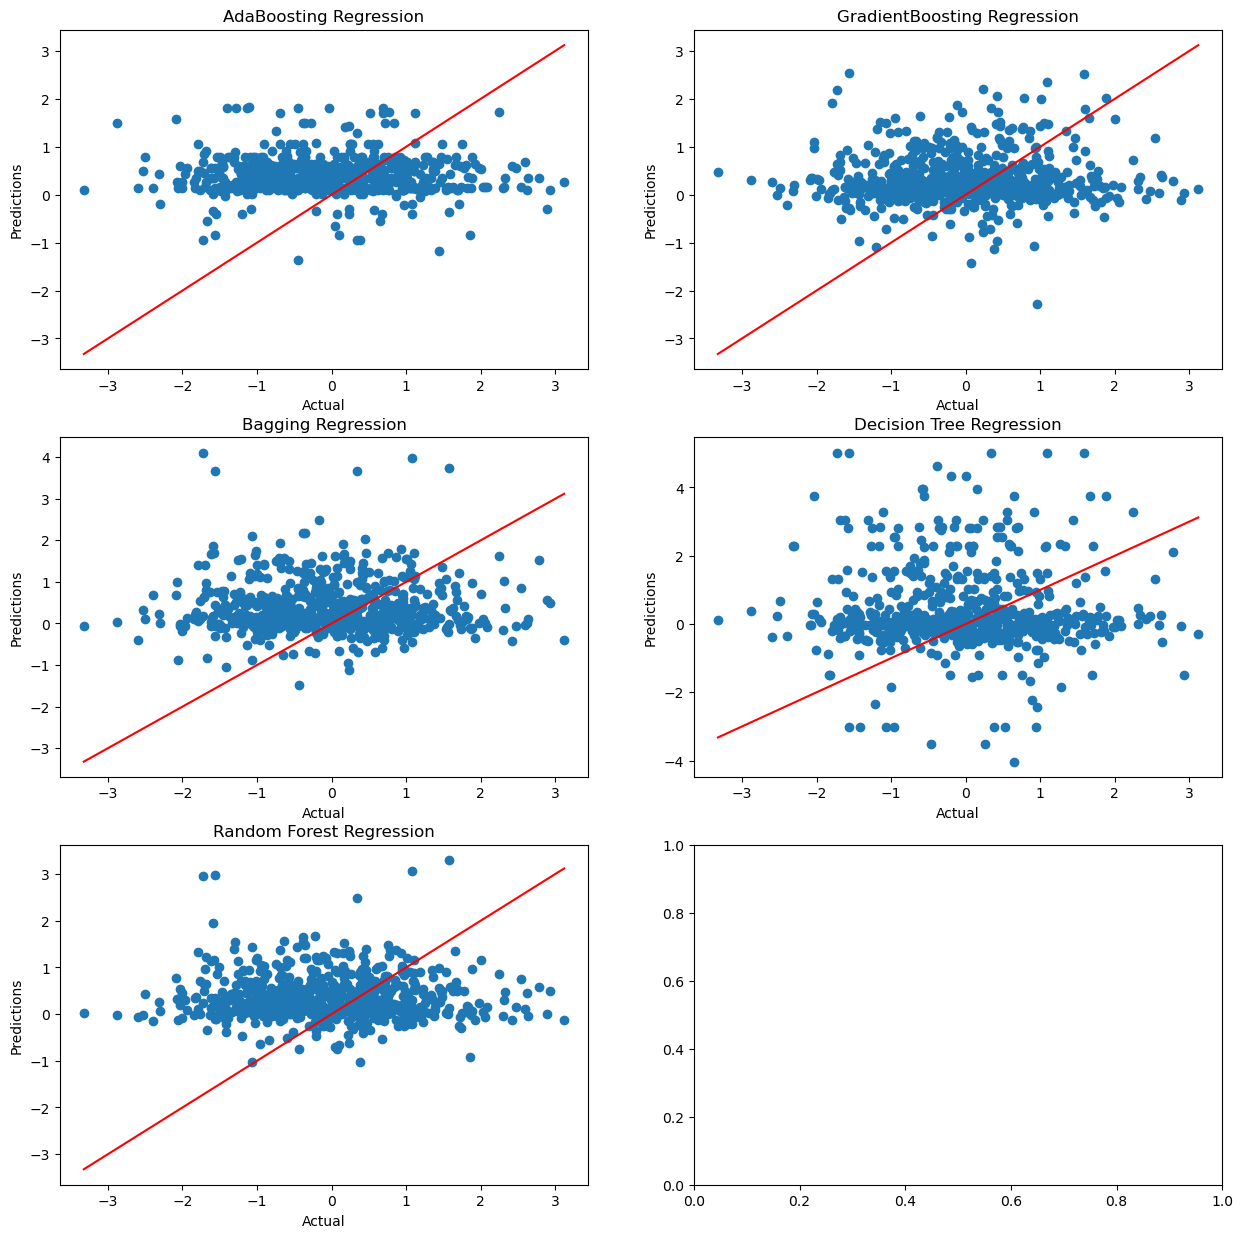

In [44]:
# create subplot, 3 row, 2 columns
plt.subplots(3, 2, figsize=(15, 15))

# plot AdaBoosting regression predictions
plotPredictions(321, Y_test['TARGET'], ab_predictions, 'AdaBoosting Regression')

# plot GradientBoosting regression predictions
plotPredictions(322, Y_test['TARGET'], gb_predictions, 'GradientBoosting Regression')

# plot Bagging regression predictions
plotPredictions(323, Y_test['TARGET'], bagging_predictions, 'Bagging Regression')

# plot decision tree regression predictions
plotPredictions(324, Y_test['TARGET'], dt_predictions, 'Decision Tree Regression')

# plot random forest regression predictions
plotPredictions(325, Y_test['TARGET'], rf_predictions, 'Random Forest Regression')

# show the plot
plt.show()

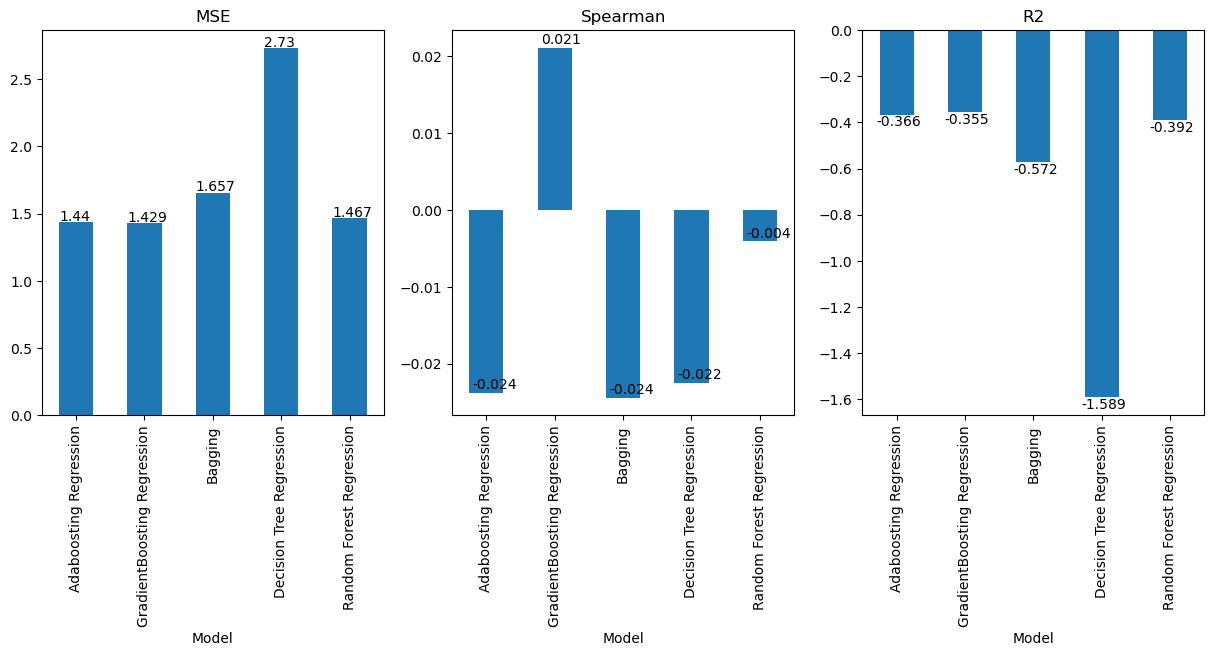

In [45]:
# Create a figure and add subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot the MSE
results.plot(x='Model', y='MSE', kind='bar', ax=axs[0], title='MSE', legend=False)
for i, v in enumerate(results['MSE']):
    axs[0].text(i - .25, v + .01, str(round(v, 3)))


# Plot the Spearman
results.plot(x='Model', y='Spearman', kind='bar', ax=axs[1], title='Spearman', legend=False)
for i, v in enumerate(results['Spearman']):
    axs[1].text(i - .2, v + .0005, str(round(v, 3)))

# Plot the R2
results.plot(x='Model', y='R2', kind='bar', ax=axs[2], title='R2', legend=False)
for i, v in enumerate(results['R2']):
    axs[2].text(i - .3, v - .05, str(round(v, 3)))

# Show the plot
plt.show()

### Hyperparameters tuning

In [46]:
def spearman_score(y_pred, y_true):
    return spearmanr(y_true, y_pred)[0]

AdaBoosting

In [68]:
param_grid = {
    'n_estimators': [50, 75, 100, 125, 150, 200], 
    'learning_rate': [0.01, 0.05, 0.1, 0.5, 1.0] 
}

grid = GridSearchCV(
    estimator=ab,
    param_grid=param_grid,
    cv=10,
    scoring=make_scorer(spearman_score),
    n_jobs=-1,
    return_train_score=True
);

grid.fit(X_train, Y_train['TARGET']);

In [69]:
p = grid.best_estimator_.predict(X_test)
results = evaluateModel("Adaboosting Regression (tuned)", p, results)

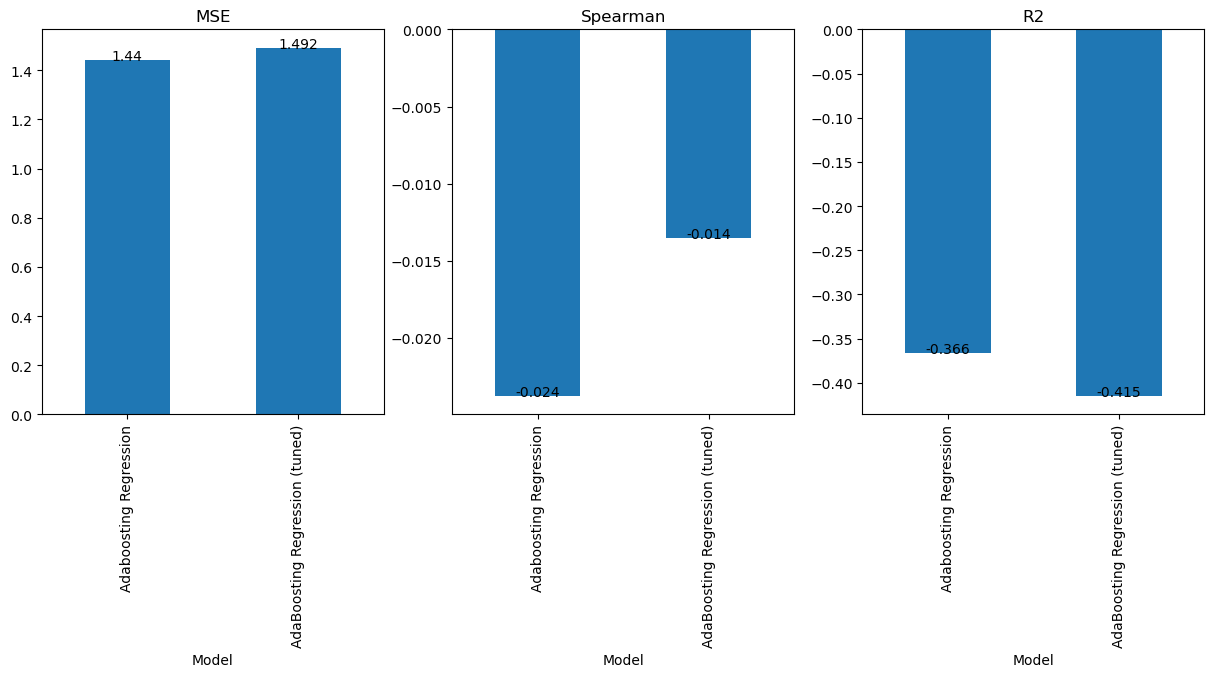

In [72]:
compare = results[results['Model'].isin(['Adaboosting Regression', 'AdaBoosting Regression (tuned)'])]

# plot each metric seperately with subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
compare.plot(x='Model', y='MSE', kind='bar', ax=axs[0], title='MSE', legend=False)
compare.plot(x='Model', y='Spearman', kind='bar', ax=axs[1], title='Spearman', legend=False)
compare.plot(x='Model', y='R2', kind='bar', ax=axs[2], title='R2', legend=False)

# add values to the plot
for i, v in enumerate(compare['MSE']):
    axs[0].text(i, v, str(round(v, 3)), ha='center')
for i, v in enumerate(compare['Spearman']):
    axs[1].text(i, v, str(round(v, 3)), ha='center')
for i, v in enumerate(compare['R2']):
    axs[2].text(i, v, str(round(v, 3)), ha='center')

plt.show()

GradientBoosting

In [75]:
param_grid = {
    'n_estimators': [50, 100, 150, 200], 
    'learning_rate': [0.01, 0.1, 1.0], 
    'max_depth': [3, 4, 5],  
    'min_samples_split': [2, 4, 6], 
    'min_samples_leaf': [1, 2, 4]  
}

grid = GridSearchCV(
    estimator=gb,
    param_grid=param_grid,
    cv=10,
    scoring=make_scorer(spearman_score),
    n_jobs=-1,
    return_train_score=True
);

grid.fit(X_train, Y_train['TARGET']);

In [77]:
p = grid.best_estimator_.predict(X_test)
results = evaluateModel("GradientBoosting Regression (tuned)", p, results)

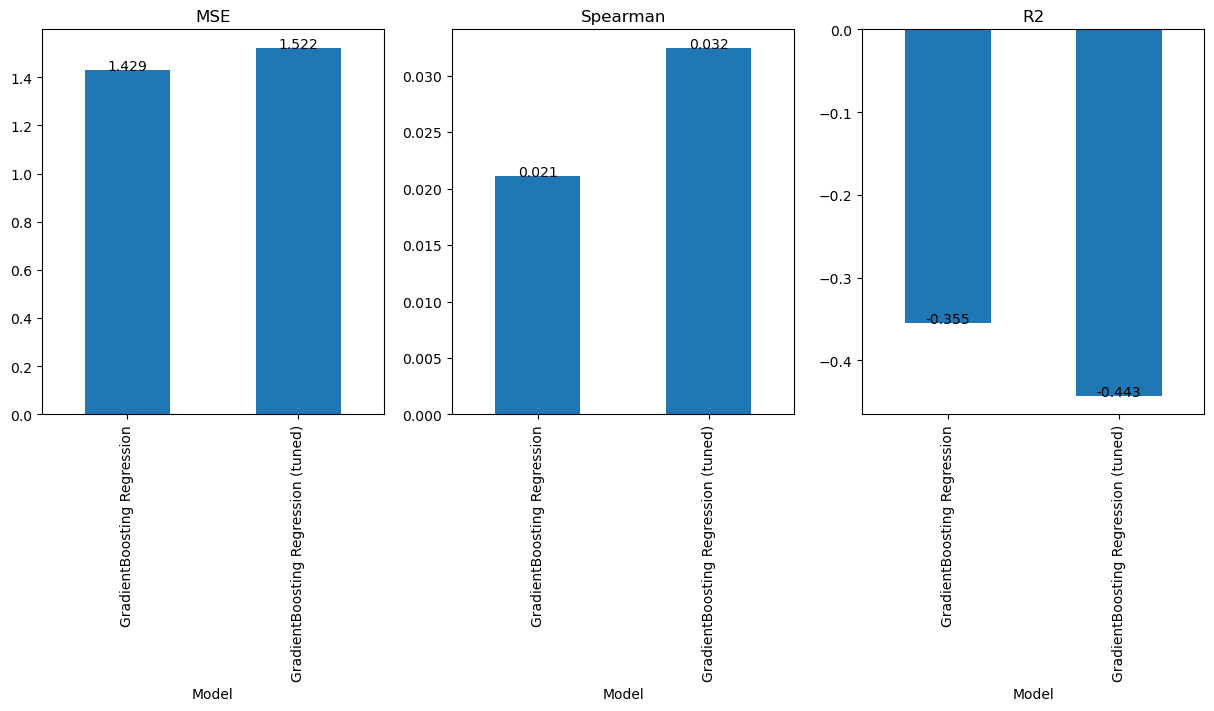

In [78]:
compare = results[results['Model'].isin(['GradientBoosting Regression', 'GradientBoosting Regression (tuned)'])]

# plot each metric seperately with subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
compare.plot(x='Model', y='MSE', kind='bar', ax=axs[0], title='MSE', legend=False)
compare.plot(x='Model', y='Spearman', kind='bar', ax=axs[1], title='Spearman', legend=False)
compare.plot(x='Model', y='R2', kind='bar', ax=axs[2], title='R2', legend=False)

# add values to the plot
for i, v in enumerate(compare['MSE']):
    axs[0].text(i, v, str(round(v, 3)), ha='center')
for i, v in enumerate(compare['Spearman']):
    axs[1].text(i, v, str(round(v, 3)), ha='center')
for i, v in enumerate(compare['R2']):
    axs[2].text(i, v, str(round(v, 3)), ha='center')

plt.show()

Bagging

In [91]:
param_grid = {
    'n_estimators': [25,50,100],  
    'max_samples': np.arange(0.25, 1.01, 0.25), 
    'max_features': np.arange(0.5, 1.01, 0.1), 
    'bootstrap': [True, False] 
}

grid = GridSearchCV(
    estimator=bagging,
    param_grid=param_grid,
    cv=10,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    return_train_score=True
);

grid.fit(X_train, Y_train['TARGET']);

In [92]:
print("Best Parameters:", grid.best_params_)

Best Parameters: {'bootstrap': False, 'max_features': 0.6, 'max_samples': 0.25, 'n_estimators': 100}


In [93]:
p = grid.best_estimator_.predict(X_test)
results = evaluateModel("Bagging Regression (tuned)", p, results)

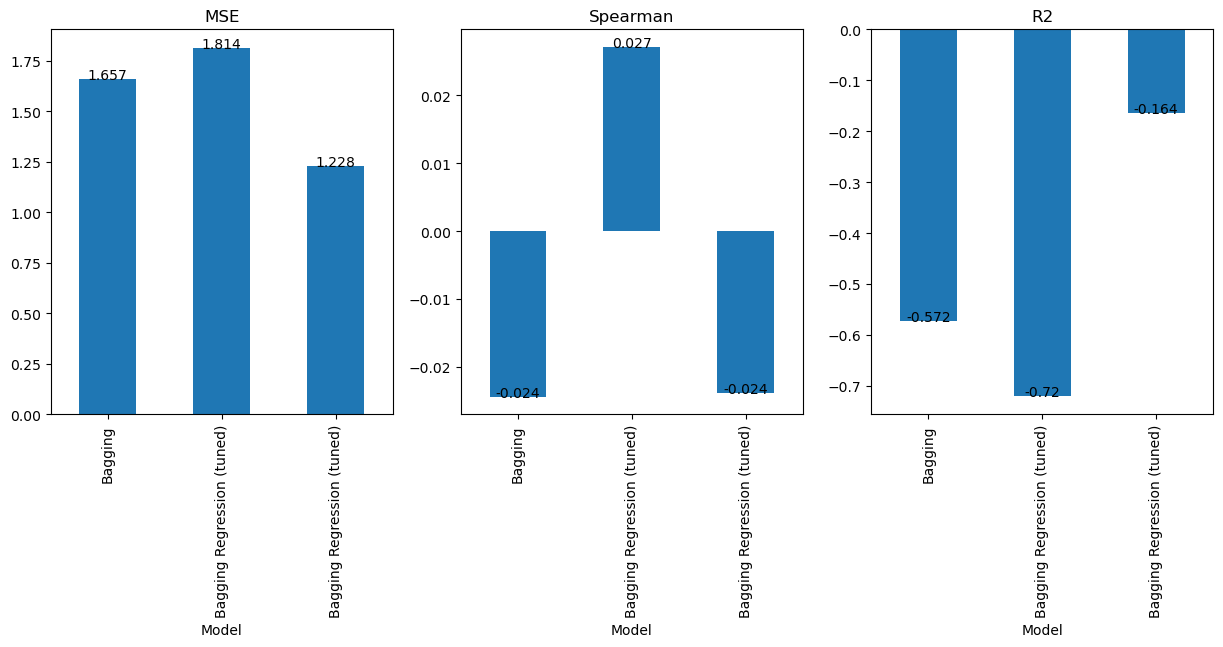

In [94]:
compare = results[results['Model'].isin(['Bagging', 'Bagging Regression (tuned)'])]

# plot each metric seperately with subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
compare.plot(x='Model', y='MSE', kind='bar', ax=axs[0], title='MSE', legend=False)
compare.plot(x='Model', y='Spearman', kind='bar', ax=axs[1], title='Spearman', legend=False)
compare.plot(x='Model', y='R2', kind='bar', ax=axs[2], title='R2', legend=False)

# add values to the plot
for i, v in enumerate(compare['MSE']):
    axs[0].text(i, v, str(round(v, 3)), ha='center')
for i, v in enumerate(compare['Spearman']):
    axs[1].text(i, v, str(round(v, 3)), ha='center')
for i, v in enumerate(compare['R2']):
    axs[2].text(i, v, str(round(v, 3)), ha='center')

plt.show()

Random Forest

In [54]:
param_grid = {
    #'criterion' : ["squared_error", "friedman_mse", "absolute_error", "poisson"],
    #'max_depth': np.arange(1, 20),
    'min_samples_leaf': np.arange(1, 10),
    'max_leaf_nodes': np.arange(2, 20),
    #'min_impurity_decrease': np.arange(0.0, 1.0),

}

grid = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=10,
    scoring=make_scorer(spearman_score),
    n_jobs=-1,
    return_train_score=True
);

# Fit the GridSearchCV object to the data
grid.fit(X_train, Y_train['TARGET']);

In [57]:
p = grid.best_estimator_.predict(X_test)
results = evaluateModel("Random Forest Regression (tuned)", p, results)

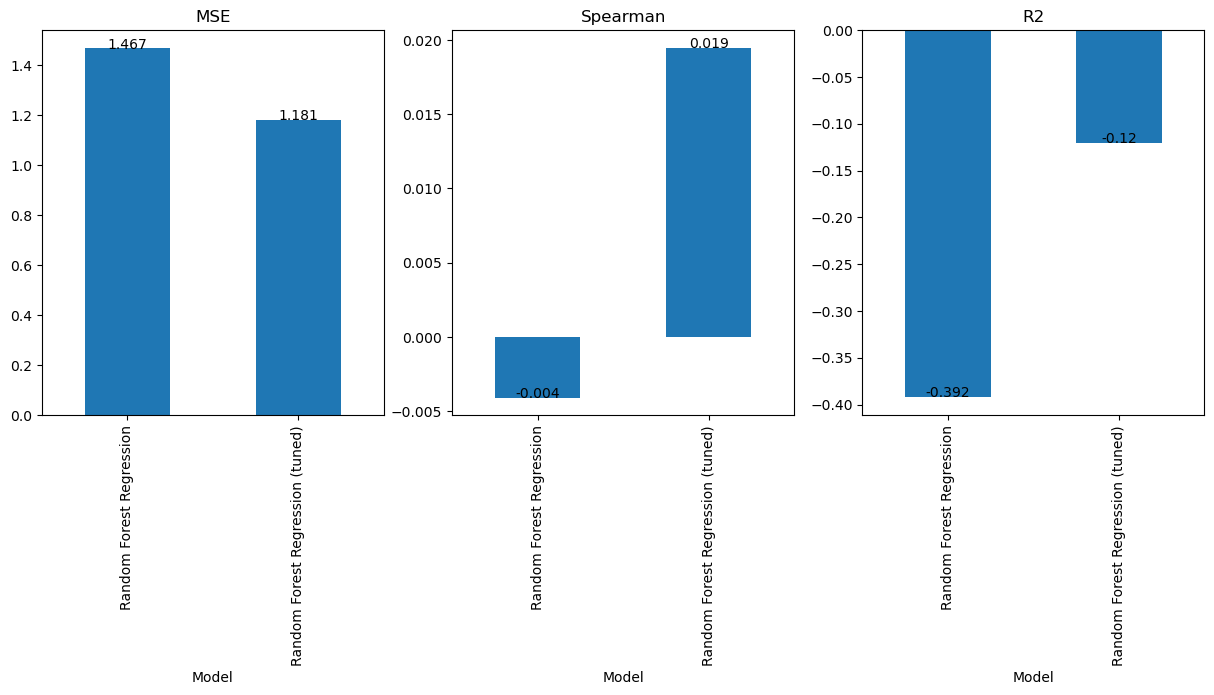

In [58]:
compare = results[results['Model'].isin(['Random Forest Regression', 'Random Forest Regression (tuned)'])]

# plot each metric seperately with subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
compare.plot(x='Model', y='MSE', kind='bar', ax=axs[0], title='MSE', legend=False)
compare.plot(x='Model', y='Spearman', kind='bar', ax=axs[1], title='Spearman', legend=False)
compare.plot(x='Model', y='R2', kind='bar', ax=axs[2], title='R2', legend=False)

# add values to the plot
for i, v in enumerate(compare['MSE']):
    axs[0].text(i, v, str(round(v, 3)), ha='center')
for i, v in enumerate(compare['Spearman']):
    axs[1].text(i, v, str(round(v, 3)), ha='center')
for i, v in enumerate(compare['R2']):
    axs[2].text(i, v, str(round(v, 3)), ha='center')

plt.show()

Decision Tree

In [64]:
param_grid = {
    'criterion' : ["squared_error", "friedman_mse", "absolute_error", "poisson"],
    'max_depth': np.arange(1, 20),
    'min_samples_leaf': np.arange(1, 50),
    #'max_leaf_nodes': np.arange(2, 100),
    #'min_impurity_decrease': np.arange(0.0, 1.0),
    #'min_impurity_split': np.arange(0.0, 1.0),
    #'ccp_alpha': np.arange(0.0, 1.0),
    #'random_state': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
    #'presort': [True, False],
    #'class_weight': [None, 'balanced'],
    #'ccp_alpha': np.arange(0.0, 1.0),
    #'max_samples': np.arange(0.0, 1.0)
}

grid = GridSearchCV(
    estimator=dt,
    param_grid=param_grid,
    cv=10,
    scoring=make_scorer(spearman_score),
    n_jobs=-1,
    return_train_score=True
);

# Fit the GridSearchCV object to the data
grid.fit(X_train, Y_train['TARGET']);

d:\Anaconda\Lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
9310 fits failed out of a total of 37240.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
9310 fits failed with the following error:
Traceback (most recent call last):
  File "d:\Anaconda\Lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "d:\Anaconda\Lib\site-packages\sklearn\tree\_classes.py", line 1247, in fit
    super().fit(
  File "d:\Anaconda\Lib\site-packages\sklearn\tree\_classes.py", line 199, in fit
    raise ValueError(
ValueError: Some value(s) of y are negative which is not allowed for Poisson regression.

  warnings.warn(some_fits_failed_me

In [65]:
p = grid.best_estimator_.predict(X_test)
results = evaluateModel("Decision Tree Regression (tuned)", p, results)

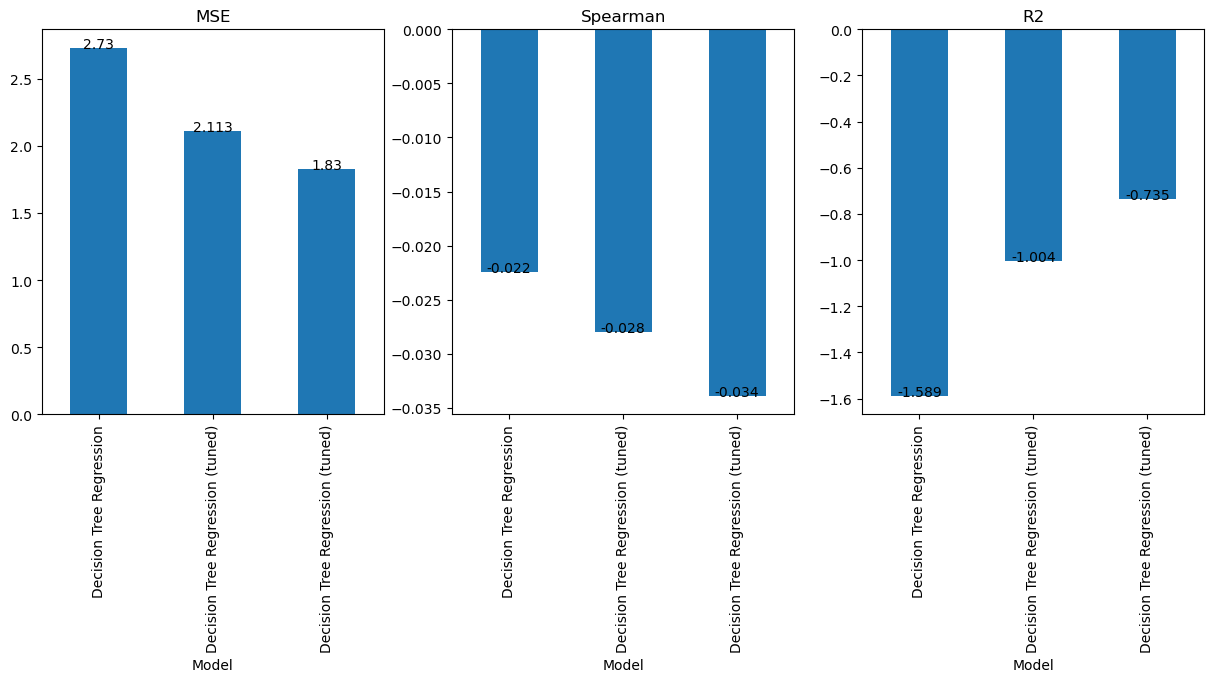

In [67]:
compare = results[results['Model'].isin(['Decision Tree Regression', 'Decision Tree Regression (tuned)'])]

# plot each metric seperately with subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
compare.plot(x='Model', y='MSE', kind='bar', ax=axs[0], title='MSE', legend=False)
compare.plot(x='Model', y='Spearman', kind='bar', ax=axs[1], title='Spearman', legend=False)
compare.plot(x='Model', y='R2', kind='bar', ax=axs[2], title='R2', legend=False)

# add values to the plot
for i, v in enumerate(compare['MSE']):
    axs[0].text(i, v, str(round(v, 3)), ha='center')
for i, v in enumerate(compare['Spearman']):
    axs[1].text(i, v, str(round(v, 3)), ha='center')
for i, v in enumerate(compare['R2']):
    axs[2].text(i, v, str(round(v, 3)), ha='center')

plt.show()

XGBoost

In [95]:
# Convert the data into DMatrix format, which is optimized for XGBoost
dtrain = xgb.DMatrix(X_train, label=Y_train['TARGET'])
dtest = xgb.DMatrix(X_test, label=Y_test['TARGET'])

In [96]:
xgb_model = xgb.XGBRegressor()

In [102]:
# Define parameters for XGBoost
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2], 
    'max_depth': [3, 5, 7],             
    'subsample': [0.8, 0.9, 1.0],       
    'colsample_bytree': [0.8, 0.9, 1.0], 
    'n_estimators': [100, 200, 300]   
}

grid = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    cv=10,
    scoring=make_scorer(spearman_score),
    n_jobs=-1,
    return_train_score=True
);

# Fit the GridSearchCV object to the data
grid.fit(X_train, Y_train['TARGET']);

In [107]:
print("Best Parameters:", grid.best_params_)
best_params = grid.best_params_

Best Parameters: {'colsample_bytree': 0.9, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.8}


In [108]:
best_xgb_model = xgb.XGBRegressor(**best_params)
best_xgb_model.fit(X_train, Y_train['TARGET'])
y_pred = best_xgb_model.predict(X_test)

In [109]:
mse = mean_squared_error(Y_test['TARGET'], y_pred)
print("Mean Squared Error (MSE):", mse)

r2 = r2_score(Y_test['TARGET'], y_pred)
print("R^2 Score:", r2)

spearman_corr, _ = spearmanr(Y_test['TARGET'], y_pred)
print("Spearman Correlation:", spearman_corr)

Mean Squared Error (MSE): 1.455587012318637
R^2 Score: -0.38045309021253315
Spearman Correlation: -0.052156246973596734


It is not useful to preprocess data in such way to use XGBoost, so we use another way to do so.
______

## Another data preprocessing method

In [57]:
X_train = pd.read_csv('data/X_train_NHkHMNU.csv')
Y_train = pd.read_csv('data/y_train_ZAN5mwg.csv')
X_test = pd.read_csv('data/X_test_final.csv')
Y_test = pd.read_csv('data/y_test_random_final.csv')

In [58]:
X_train[['DE_FR_EXCHANGE','FR_DE_EXCHANGE','DE_TEMP','FR_TEMP']] = (
    X_train[['DE_FR_EXCHANGE','FR_DE_EXCHANGE','DE_TEMP','FR_TEMP']]).fillna(
    X_train[['DE_FR_EXCHANGE','FR_DE_EXCHANGE','DE_TEMP','FR_TEMP']].mean())

In [59]:
X_train[['DE_NET_EXPORT','FR_NET_EXPORT','DE_NET_IMPORT','FR_NET_IMPORT','DE_RAIN','FR_RAIN','DE_WIND','FR_WIND']]=(
    X_train[['DE_NET_EXPORT','FR_NET_EXPORT','DE_NET_IMPORT','FR_NET_IMPORT','DE_RAIN','FR_RAIN','DE_WIND','FR_WIND']]).fillna(
    X_train[['DE_NET_EXPORT','FR_NET_EXPORT','DE_NET_IMPORT','FR_NET_IMPORT','DE_RAIN','FR_RAIN','DE_WIND','FR_WIND']].median()
)

In [60]:
X_test[['DE_FR_EXCHANGE','FR_DE_EXCHANGE','DE_TEMP','FR_TEMP']] = (
    X_test[['DE_FR_EXCHANGE','FR_DE_EXCHANGE','DE_TEMP','FR_TEMP']]).fillna(
    X_test[['DE_FR_EXCHANGE','FR_DE_EXCHANGE','DE_TEMP','FR_TEMP']].mean())

In [61]:
X_test[['DE_NET_EXPORT','FR_NET_EXPORT','DE_NET_IMPORT','FR_NET_IMPORT','DE_RAIN','FR_RAIN','DE_WIND','FR_WIND']]=(
    X_test[['DE_NET_EXPORT','FR_NET_EXPORT','DE_NET_IMPORT','FR_NET_IMPORT','DE_RAIN','FR_RAIN','DE_WIND','FR_WIND']]).fillna(
    X_test[['DE_NET_EXPORT','FR_NET_EXPORT','DE_NET_IMPORT','FR_NET_IMPORT','DE_RAIN','FR_RAIN','DE_WIND','FR_WIND']].median()
)

In [62]:
X_train.drop(columns=['DE_FR_EXCHANGE','DE_NET_EXPORT','FR_NET_EXPORT'],inplace=True)

In [63]:
X_test.drop(columns=['DE_FR_EXCHANGE','DE_NET_EXPORT','FR_NET_EXPORT'],inplace=True)

In [64]:
merge_train_df = pd.merge(X_train,Y_train, on='ID', how= 'inner').sort_values(by='DAY_ID')
merge_test_df = pd.merge(X_test,Y_test, on='ID', how= 'inner').sort_values(by='DAY_ID')

Split the dataset into french and german set

In [65]:
fr_train_df = merge_train_df[merge_train_df['COUNTRY']=="FR"]
de_train_df = merge_train_df[merge_train_df['COUNTRY']=="DE"]
fr_test_df = merge_test_df[merge_test_df['COUNTRY']=="FR"]
de_test_df = merge_test_df[merge_test_df['COUNTRY']=="DE"]

In [66]:
X_train_fr = fr_train_df[["COUNTRY","DAY_ID","FR_CONSUMPTION","FR_DE_EXCHANGE","FR_NET_IMPORT","FR_GAS","FR_COAL",
                          "FR_HYDRO","FR_NUCLEAR","FR_SOLAR","FR_WINDPOW","FR_RESIDUAL_LOAD","FR_RAIN",
                          "FR_WIND","FR_TEMP","GAS_RET","COAL_RET","CARBON_RET"]]
print(X_train_fr['COUNTRY'].unique())
X_train_fr.drop(columns='COUNTRY',inplace=True)

['FR']


/var/folders/sy/vmc9d9hj20b8m5tcq23j8d7r0000gn/T/ipykernel_31476/998683249.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fr.drop(columns='COUNTRY',inplace=True)


In [67]:
X_test_fr = fr_test_df[["COUNTRY","DAY_ID","FR_CONSUMPTION","FR_DE_EXCHANGE","FR_NET_IMPORT","FR_GAS","FR_COAL",
                          "FR_HYDRO","FR_NUCLEAR","FR_SOLAR","FR_WINDPOW","FR_RESIDUAL_LOAD","FR_RAIN",
                          "FR_WIND","FR_TEMP","GAS_RET","COAL_RET","CARBON_RET"]]
print(X_test_fr['COUNTRY'].unique())
X_test_fr.drop(columns='COUNTRY',inplace=True)

['FR']


/var/folders/sy/vmc9d9hj20b8m5tcq23j8d7r0000gn/T/ipykernel_31476/424382779.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_fr.drop(columns='COUNTRY',inplace=True)


In [68]:
Y_train_fr = fr_train_df[['ID','TARGET']]

In [69]:
Y_test_fr = fr_test_df[['ID','TARGET']]

In [70]:
X_train.columns

Index(['ID', 'DAY_ID', 'COUNTRY', 'DE_CONSUMPTION', 'FR_CONSUMPTION',
       'FR_DE_EXCHANGE', 'DE_NET_IMPORT', 'FR_NET_IMPORT', 'DE_GAS', 'FR_GAS',
       'DE_COAL', 'FR_COAL', 'DE_HYDRO', 'FR_HYDRO', 'DE_NUCLEAR',
       'FR_NUCLEAR', 'DE_SOLAR', 'FR_SOLAR', 'DE_WINDPOW', 'FR_WINDPOW',
       'DE_LIGNITE', 'DE_RESIDUAL_LOAD', 'FR_RESIDUAL_LOAD', 'DE_RAIN',
       'FR_RAIN', 'DE_WIND', 'FR_WIND', 'DE_TEMP', 'FR_TEMP', 'GAS_RET',
       'COAL_RET', 'CARBON_RET'],
      dtype='object')

In [71]:
X_train_de = de_train_df[["COUNTRY","DAY_ID","DE_CONSUMPTION","FR_DE_EXCHANGE","DE_NET_IMPORT","DE_GAS",
                          "DE_COAL","DE_HYDRO","DE_NUCLEAR","DE_SOLAR","DE_WINDPOW","DE_LIGNITE",
                          "DE_RESIDUAL_LOAD","DE_RAIN","DE_WIND","DE_TEMP","GAS_RET","COAL_RET","CARBON_RET"]]
print(X_train_de['COUNTRY'].unique())
X_train_de.drop(columns='COUNTRY',inplace=True)

['DE']


/var/folders/sy/vmc9d9hj20b8m5tcq23j8d7r0000gn/T/ipykernel_31476/3673246252.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_de.drop(columns='COUNTRY',inplace=True)


In [72]:
X_test_de = de_test_df[["COUNTRY","DAY_ID","DE_CONSUMPTION","FR_DE_EXCHANGE","DE_NET_IMPORT","DE_GAS",
                          "DE_COAL","DE_HYDRO","DE_NUCLEAR","DE_SOLAR","DE_WINDPOW","DE_LIGNITE",
                          "DE_RESIDUAL_LOAD","DE_RAIN","DE_WIND","DE_TEMP","GAS_RET","COAL_RET","CARBON_RET"]]
print(X_test_de['COUNTRY'].unique())
X_test_de.drop(columns='COUNTRY',inplace=True)

['DE']


/var/folders/sy/vmc9d9hj20b8m5tcq23j8d7r0000gn/T/ipykernel_31476/3105680706.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_de.drop(columns='COUNTRY',inplace=True)


In [73]:
Y_train_de = de_train_df[['ID','TARGET']]

In [74]:
Y_test_de = de_test_df[['ID','TARGET']]

# Gradient_Boosting_Tree


In [75]:
from sklearn.ensemble import GradientBoostingRegressor

gb_regressor = GradientBoostingRegressor(
    loss='squared_error',           # Least squares regression (other options: 'lad', 'huber', 'quantile')
    learning_rate=0.1,   # Learning rate (shrinkage parameter)
    n_estimators=100,    # Number of boosting stages (trees) to be fit
    max_depth=3,         # Maximum depth of the individual trees
    min_samples_split=2, # Minimum number of samples required to split an internal node
    min_samples_leaf=1,  # Minimum number of samples required to be at a leaf node
    random_state=42      # Seed for random number generation
)

# Train the model
gb_regressor.fit(X_train_fr, Y_train_fr['TARGET'])

# Make predictions on the test set
predictions = gb_regressor.predict(X_test_fr)

# Calculate Mean Squared Error
mse = mean_squared_error(Y_test_fr['TARGET'], predictions)
print("Mean Squared Error:", mse)

Mean Squared Error: 1.277129312714785


In [76]:
def objective(trial):
    # Define search space for hyperparameters
    params = {
        'loss': 'squared_error',                                  # Least squares regression
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.5),
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'max_depth': trial.suggest_int('max_depth', 2, 20),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
        'random_state': 42                              # Seed for random number generation
    }
    
    # Initialize Gradient Boosting Regressor with parameters suggested by Optuna
    gb_regressor = GradientBoostingRegressor(**params)
    
    # Train the model
    gb_regressor.fit(X_train_fr, Y_train_fr['TARGET'])
    
    # Make predictions on the test set
    predictions_fr = gb_regressor.predict(X_test_fr)
    
    # Calculate Mean Squared Error
    mse = mean_squared_error(Y_test_fr['TARGET'], predictions_fr)
    
    return mse

# Create study object and optimize parameters
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

# Get the best parameters
best_params = study.best_params
print("Best Parameters for FR:", best_params)

# Train the model with best parameters
best_model_fr = GradientBoostingRegressor(**best_params)
best_model_fr.fit(X_train_fr, Y_train_fr['TARGET'])

# Make predictions on the test set
predictions_fr = best_model_fr.predict(X_test_fr)

# Calculate Mean Squared Error for the best model
mse = mean_squared_error(Y_test_fr['TARGET'], predictions_fr)
print("Mean Squared Error for Best Model_FR:", mse)

[I 2024-03-04 12:33:39,908] A new study created in memory with name: no-name-0f369deb-714a-40bb-9430-c33a0d661eff
/var/folders/sy/vmc9d9hj20b8m5tcq23j8d7r0000gn/T/ipykernel_31476/939424747.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.5),
[I 2024-03-04 12:33:45,322] Trial 0 finished with value: 1.3361586352966264 and parameters: {'learning_rate': 0.04636366275010342, 'n_estimators': 465, 'max_depth': 18, 'min_samples_split': 17, 'min_samples_leaf': 9}. Best is trial 0 with value: 1.3361586352966264.
/var/folders/sy/vmc9d9hj20b8m5tcq23j8d7r0000gn/T/ipykernel_31476/939424747.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float

Best Parameters for FR: {'learning_rate': 0.01170784715308349, 'n_estimators': 50, 'max_depth': 9, 'min_samples_split': 13, 'min_samples_leaf': 6}
Mean Squared Error for Best Model_FR: 1.1183122056567056


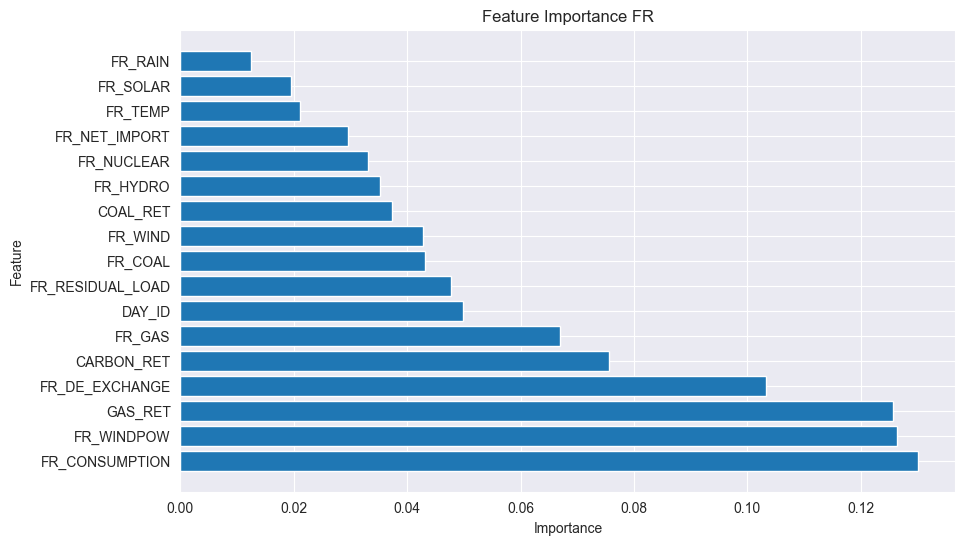

In [77]:
# Get feature importances
feature_importances = best_model_fr.feature_importances_

# Create a DataFrame to display feature importances
feature_importance_df = pd.DataFrame({'Feature': list(X_train_fr.columns), 'Importance': feature_importances})

# Sort the DataFrame by importance scores
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance FR')
plt.show()

In [78]:
def objective(trial):
    # Define search space for hyperparameters
    params = {
        'loss': 'squared_error',                                  # Least squares regression
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.5),
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'max_depth': trial.suggest_int('max_depth', 4, 40),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
        'random_state': 42                              # Seed for random number generation
    }
    
    # Initialize Gradient Boosting Regressor with parameters suggested by Optuna
    gb_regressor = GradientBoostingRegressor(**params)
    
    # Train the model
    gb_regressor.fit(X_train_de, Y_train_de['TARGET'])
    
    # Make predictions on the test set
    predictions_de = gb_regressor.predict(X_test_de)
    
    # Calculate Mean Squared Error
    mse = mean_squared_error(Y_test_de['TARGET'], predictions_de)
    
    return mse

# Create study object and optimize parameters
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

# Get the best parameters
best_params = study.best_params
print("Best Parameters for DE:", best_params)

# Train the model with best parameters
best_model_de = GradientBoostingRegressor(**best_params)
best_model_de.fit(X_train_de, Y_train_de['TARGET'])

# Make predictions on the test set
predictions_de = best_model_de.predict(X_test_de)

# Calculate Mean Squared Error for the best model
mse = mean_squared_error(Y_test_de['TARGET'], predictions_de)
print("Mean Squared Error for Best Model:", mse)


[I 2024-03-04 12:35:50,718] A new study created in memory with name: no-name-7052a56a-fdd1-4a8c-9d93-bfa0516e98ed
/var/folders/sy/vmc9d9hj20b8m5tcq23j8d7r0000gn/T/ipykernel_31476/3491471996.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.5),
[I 2024-03-04 12:35:52,996] Trial 0 finished with value: 1.5050377990537778 and parameters: {'learning_rate': 0.3006995869631249, 'n_estimators': 321, 'max_depth': 29, 'min_samples_split': 4, 'min_samples_leaf': 13}. Best is trial 0 with value: 1.5050377990537778.
/var/folders/sy/vmc9d9hj20b8m5tcq23j8d7r0000gn/T/ipykernel_31476/3491471996.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_floa

Best Parameters for DE: {'learning_rate': 0.01009371773561202, 'n_estimators': 60, 'max_depth': 5, 'min_samples_split': 12, 'min_samples_leaf': 4}
Mean Squared Error for Best Model: 1.0223312506416482


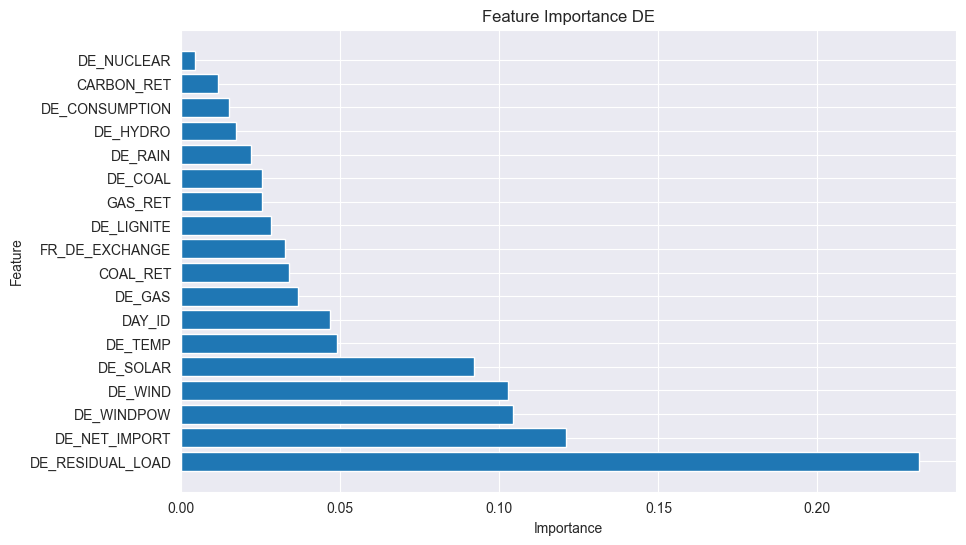

In [79]:
# Get feature importances
feature_importances = best_model_de.feature_importances_

# Create a DataFrame to display feature importances
feature_importance_df = pd.DataFrame({'Feature': list(X_train_de.columns), 'Importance': feature_importances})

# Sort the DataFrame by importance scores
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance DE')
plt.show()

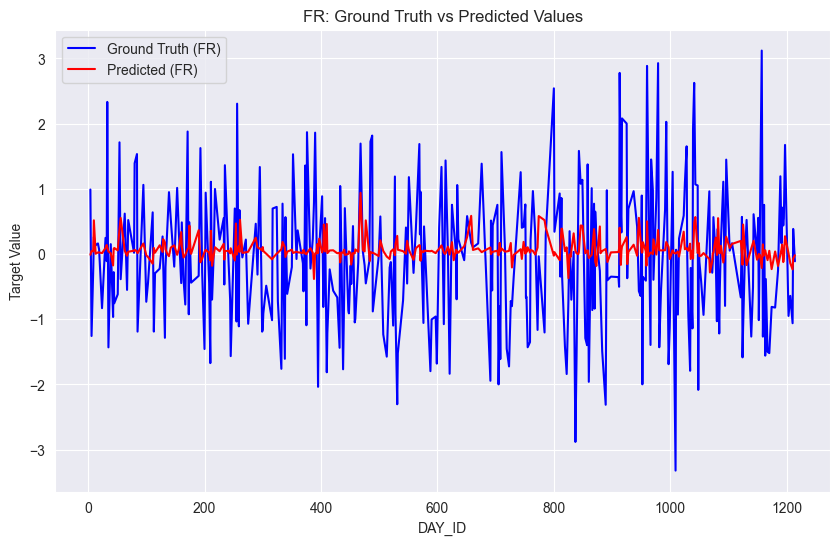

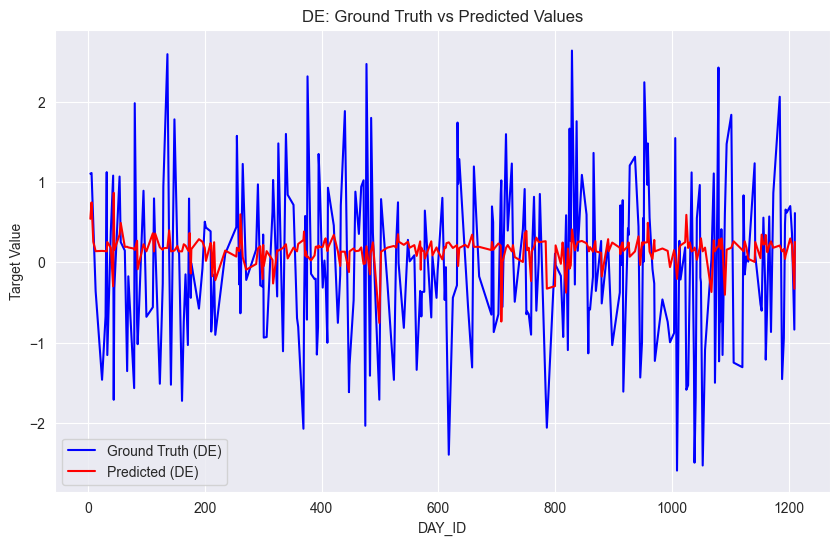

In [80]:
# Assuming Y_test_fr and predictions_fr are the target values for the FR model
# Assuming Y_test_de and predictions_de are the target values for the DE model

# Plot the ground truth and predicted values for the FR model
plt.figure(figsize=(10, 6))
plt.plot(X_test_fr['DAY_ID'], Y_test_fr['TARGET'], color='blue', label='Ground Truth (FR)')
plt.plot(X_test_fr['DAY_ID'], predictions_fr, color='red', label='Predicted (FR)')
plt.xlabel('DAY_ID')
plt.ylabel('Target Value')
plt.title('FR: Ground Truth vs Predicted Values')
plt.legend()
plt.show()

# Plot the ground truth and predicted values for the DE model
plt.figure(figsize=(10, 6))
plt.plot(X_test_de['DAY_ID'], Y_test_de['TARGET'], color='blue', label='Ground Truth (DE)')
plt.plot(X_test_de['DAY_ID'], predictions_de, color='red', label='Predicted (DE)')
plt.xlabel('DAY_ID')
plt.ylabel('Target Value')
plt.title('DE: Ground Truth vs Predicted Values')
plt.legend()
plt.show()


In [81]:
predictions = np.concatenate([predictions_fr, predictions_de], axis=0)
groundtruth = pd.concat([Y_test_fr['TARGET'], Y_test_de['TARGET']], axis=0)



def metric_train(output, y):
    return spearmanr(output, y).correlation

print(
    'Spearman correlation for the test set_fr: {:.1f}%'.format(100 * metric_train(predictions_fr, Y_test_fr['TARGET'])))

print(
    'Spearman correlation for the test set_de: {:.1f}%'.format(100 * metric_train(predictions_de, Y_test_de['TARGET'])))

print('Spearman correlation for the test set: {:.1f}%'.format(100 * metric_train(predictions, groundtruth)))

Spearman correlation for the test set_fr: 1.4%
Spearman correlation for the test set_de: 2.6%
Spearman correlation for the test set: 6.3%


# XGBossting Tree

In [82]:
# Convert the data into DMatrix format, which is optimized for XGBoost
dtrain_fr = xgb.DMatrix(X_train_fr, label=Y_train_fr['TARGET'])
dtest_fr = xgb.DMatrix(X_test_fr, label=Y_test_fr['TARGET'])
dtrain_de = xgb.DMatrix(X_train_de, label=Y_train_de['TARGET'])
dtest_de = xgb.DMatrix(X_test_de, label=Y_test_de['TARGET'])

# Define parameters for XGBoost
params_fr = {
    'objective': 'reg:squarederror',  # Regression task
    'eval_metric': 'rmse',             # Evaluation metric: root mean squared error
    'max_depth': 3,                    # Maximum depth of each tree
    'learning_rate': 0.1,              # Learning rate (shrinkage parameter)
    'subsample': 0.8,                  # Subsample ratio of the training instances
    'colsample_bytree': 0.8,           # Subsample ratio of columns when constructing each tree
    'n_estimators': 100                # Number of boosting rounds (trees) to build
}

params_de = {
    'objective': 'reg:squarederror',  # Regression task
    'eval_metric': 'rmse',             # Evaluation metric: root mean squared error
    'max_depth': 3,                    # Maximum depth of each tree
    'learning_rate': 0.1,              # Learning rate (shrinkage parameter)
    'subsample': 0.8,                  # Subsample ratio of the training instances
    'colsample_bytree': 0.8,           # Subsample ratio of columns when constructing each tree
    'n_estimators': 100                # Number of boosting rounds (trees) to build
}

# Train the XGBoost model with primary parameters
model_fr = xgb.train(params_fr, dtrain_fr, num_boost_round=100)
model_de = xgb.train(params_de, dtrain_de, num_boost_round=100)

# Make predictions on the test set
predictions_fr_train = model_fr.predict(dtrain_fr)
predictions_fr = model_fr.predict(dtest_fr)
predictions_de_train = model_de.predict(dtrain_de)
predictions_de = model_de.predict(dtest_de)

# Evaluate the model using root mean squared error
rmse_fr = mean_squared_error(Y_test_fr['TARGET'], predictions_fr)
print(f"Root Mean Squared Error For FR: {rmse_fr:.2f}")

rmse_de = mean_squared_error(Y_test_de['TARGET'], predictions_de)
print(f"Root Mean Squared Error For DE: {rmse_de:.2f}")


Root Mean Squared Error For FR: 1.28
Root Mean Squared Error For DE: 1.22


/Users/fabienwong/PycharmProjects/project2/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [12:37:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


Tune the model_fr

In [83]:

from sklearn.metrics import mean_squared_error

def objective(trial):
    # Define search space for hyperparameters
    params = {
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'max_depth': trial.suggest_int('max_depth', 6, 20),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.5),
        'subsample': trial.suggest_uniform('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.6, 1.0),
        'n_estimators': 100,
        'verbosity': 0
    }
    
    # Train XGBoost model
    model = xgb.train(params, dtrain_fr, num_boost_round=100)
    
    # Make predictions on the test set
    predictions = model.predict(dtest_fr)
    
    # Calculate RMSE
    rmse = mean_squared_error(Y_test_fr['TARGET'], predictions, squared=False)
    
    return rmse

# Create study object and optimize parameters
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

# Get the best parameters
best_params_fr = study.best_params
print("Best Parameters for FR:", best_params_fr)

# Train XGBoost model with best parameters for FR
best_model_fr = xgb.train(best_params_fr, dtrain_fr, num_boost_round=100)

# Make predictions on the test set for FR
predictions_fr = best_model_fr.predict(dtest_fr)

# Calculate RMSE for FR
rmse_fr = mean_squared_error(Y_test_fr['TARGET'], predictions_fr)
print(f"Root Mean Squared Error For FR: {rmse_fr:.2f}")


[I 2024-03-04 12:37:37,325] A new study created in memory with name: no-name-2f5b8d85-6b66-4ed2-a303-96d4fefb26cf
/var/folders/sy/vmc9d9hj20b8m5tcq23j8d7r0000gn/T/ipykernel_31476/3652065470.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.5),
/var/folders/sy/vmc9d9hj20b8m5tcq23j8d7r0000gn/T/ipykernel_31476/3652065470.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.6, 1.0),
/var/folders/sy/vmc9d9hj20b8m5tcq23j8d7r0000gn/T/ipykernel_31476/3652065470.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https:

Best Parameters for FR: {'max_depth': 8, 'learning_rate': 0.010977510160035831, 'subsample': 0.6121167848191643, 'colsample_bytree': 0.6455641162741961}
Root Mean Squared Error For FR: 1.12


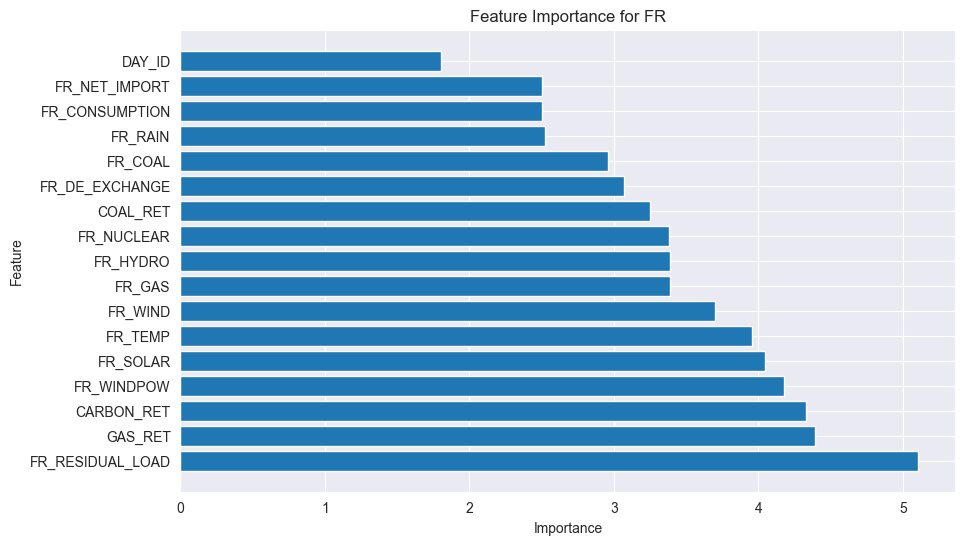

In [84]:
# Get feature importances
feature_importances = best_model_fr.get_score(importance_type='gain')

# sort the feature importance
sorted_feature_importance = sorted(feature_importances.items(), key=lambda x: x[1], reverse=True)

features = [x[0] for x in sorted_feature_importance]
importances = [x[1] for x in sorted_feature_importance]

# Create the horizontal bar plot
plt.figure(figsize=(10, 6))
plt.barh(features, importances)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance for FR')
plt.show()


In [85]:
import xgboost as xgb
import optuna
from sklearn.metrics import mean_squared_error

def objective(trial):
    # Define search space for hyperparameters
    params = {
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'max_depth': trial.suggest_int('max_depth', 2, 20),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.5),
        'subsample': trial.suggest_uniform('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.6, 1.0),
        'n_estimators': 100,
        'verbosity': 0
    }
    
    # Train XGBoost model
    model = xgb.train(params, dtrain_de, num_boost_round=100)
    
    # Make predictions on the test set
    predictions = model.predict(dtest_de)
    
    # Calculate RMSE
    rmse = mean_squared_error(Y_test_de['TARGET'], predictions, squared=False)
    
    return rmse

# Create study object and optimize parameters
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

# Get the best parameters
best_params_de = study.best_params
print("Best Parameters for DE:", best_params_de)

# Train XGBoost model with best parameters for DE
best_model_de = xgb.train(best_params_de, dtrain_de, num_boost_round=100)

# Make predictions on the test set for DE
predictions_de = best_model_de.predict(dtest_de)

# Calculate RMSE for DE
rmse_de = mean_squared_error(Y_test_de['TARGET'], predictions_de)
print(f"Root Mean Squared Error For FR: {rmse_de:.2f}")


[I 2024-03-04 12:38:24,561] A new study created in memory with name: no-name-3d848395-3944-44aa-b7c9-d4d147c439fb
/var/folders/sy/vmc9d9hj20b8m5tcq23j8d7r0000gn/T/ipykernel_31476/1949932356.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.5),
/var/folders/sy/vmc9d9hj20b8m5tcq23j8d7r0000gn/T/ipykernel_31476/1949932356.py:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.6, 1.0),
/var/folders/sy/vmc9d9hj20b8m5tcq23j8d7r0000gn/T/ipykernel_31476/1949932356.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https

Best Parameters for DE: {'max_depth': 19, 'learning_rate': 0.010008349263166906, 'subsample': 0.6426706802567972, 'colsample_bytree': 0.667069088979899}
Root Mean Squared Error For FR: 1.02


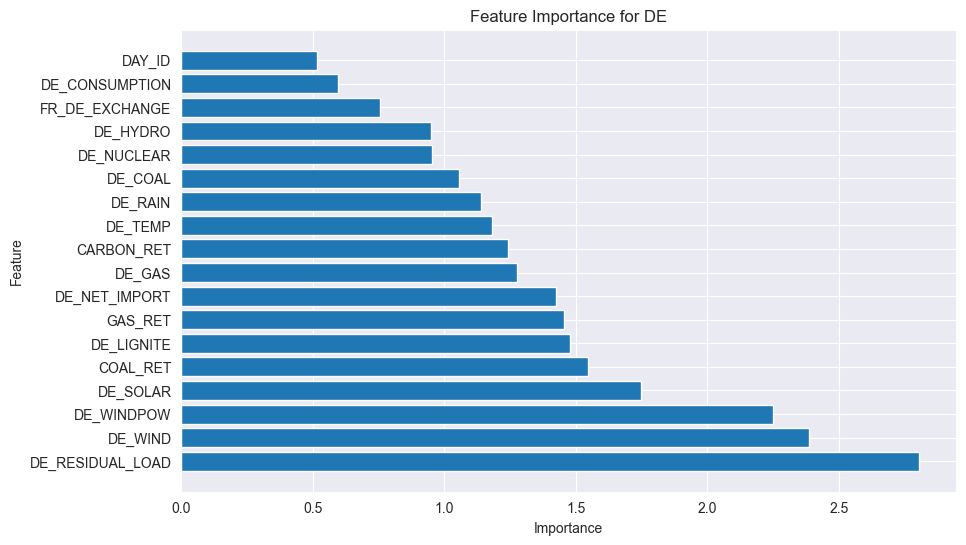

In [86]:
# Get feature importances
feature_importances = best_model_de.get_score(importance_type='gain')

# sort the feature importance
sorted_feature_importance = sorted(feature_importances.items(), key=lambda x: x[1], reverse=True)

features = [x[0] for x in sorted_feature_importance]
importances = [x[1] for x in sorted_feature_importance]

# Create the horizontal bar plot
plt.figure(figsize=(10, 6))
plt.barh(features, importances)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance for DE')
plt.show()


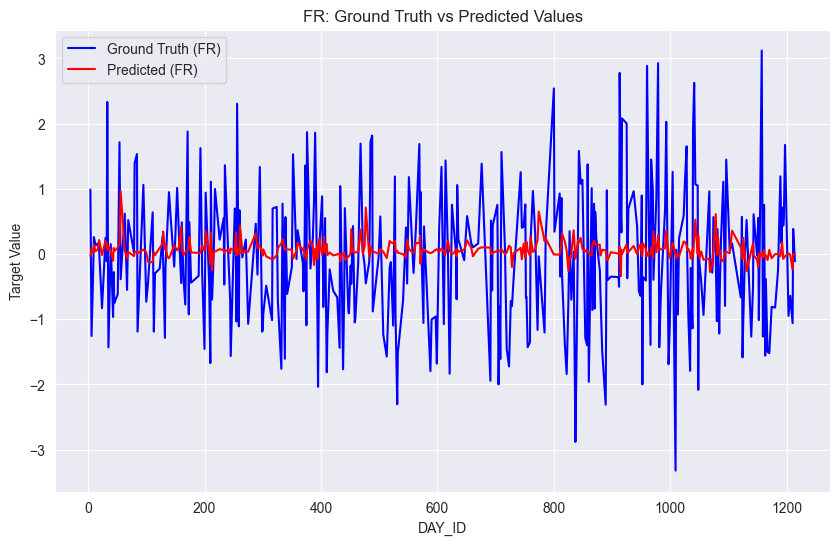

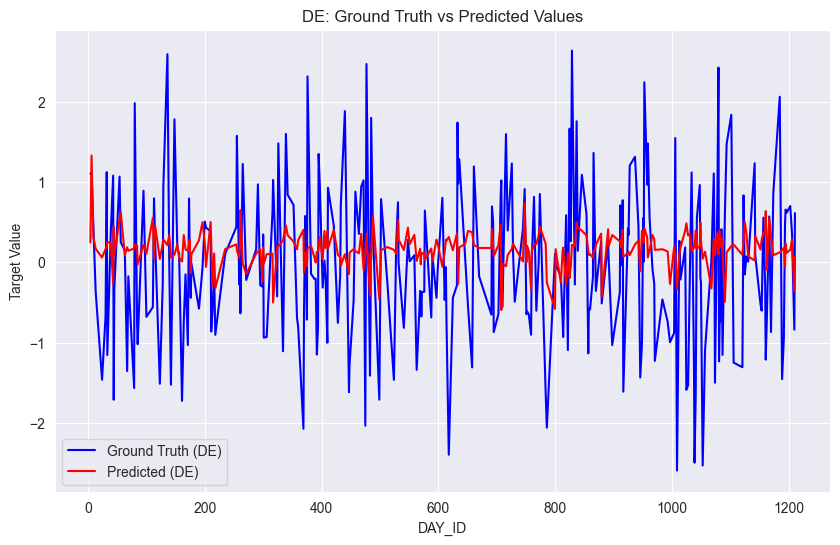

In [87]:
# Assuming Y_test_fr and predictions_fr are the target values for the FR model
# Assuming Y_test_de and predictions_de are the target values for the DE model

# Plot the ground truth and predicted values for the FR model
plt.figure(figsize=(10, 6))
plt.plot(X_test_fr['DAY_ID'], Y_test_fr['TARGET'], color='blue', label='Ground Truth (FR)')
plt.plot(X_test_fr['DAY_ID'], predictions_fr, color='red', label='Predicted (FR)')
plt.xlabel('DAY_ID')
plt.ylabel('Target Value')
plt.title('FR: Ground Truth vs Predicted Values')
plt.legend()
plt.show()

# Plot the ground truth and predicted values for the DE model
plt.figure(figsize=(10, 6))
plt.plot(X_test_de['DAY_ID'], Y_test_de['TARGET'], color='blue', label='Ground Truth (DE)')
plt.plot(X_test_de['DAY_ID'], predictions_de, color='red', label='Predicted (DE)')
plt.xlabel('DAY_ID')
plt.ylabel('Target Value')
plt.title('DE: Ground Truth vs Predicted Values')
plt.legend()
plt.show()


In [88]:
predictions = np.concatenate([predictions_fr, predictions_de],axis=0)
groundtruth = pd.concat([Y_test_fr['TARGET'],Y_test_de['TARGET']],axis=0)


In [89]:
predictions_train = np.concatenate([predictions_fr_train, predictions_de_train], axis=0)
groundtruth_train = pd.concat([Y_train_fr['TARGET'],Y_train_de['TARGET']],axis=0)

In [90]:
print('Spearman correlation for the train set_fr: {:.1f}%'.format(100 * metric_train(predictions_fr_train,Y_train_fr['TARGET'])))

print('Spearman correlation for the train set_de: {:.1f}%'.format(100 * metric_train(predictions_de_train,Y_train_de['TARGET'])))

print('Spearman correlation for the test set_fr: {:.1f}%'.format(100 * metric_train(predictions_fr,Y_test_fr['TARGET'])))

print('Spearman correlation for the test set_de: {:.1f}%'.format(100 * metric_train(predictions_de,Y_test_de['TARGET'])))

print('Spearman correlation for the train set: {:.1f}%'.format(100 * metric_train(predictions_train,groundtruth_train)))

print('Spearman correlation for the test set: {:.1f}%'.format(100 * metric_train(predictions,groundtruth)))

Spearman correlation for the train set_fr: 55.1%
Spearman correlation for the train set_de: 74.1%
Spearman correlation for the test set_fr: 8.1%
Spearman correlation for the test set_de: 10.5%
Spearman correlation for the train set: 64.1%
Spearman correlation for the test set: 10.0%


In [91]:

# Assuming predictions_array and groundtruth_array are your NumPy arrays
mse = mean_squared_error(predictions_train, groundtruth_train)
print('Mean Squared Error for train set:', mse)

mse = mean_squared_error(predictions, groundtruth)
print('Mean Squared Error for test set:', mse)


Mean Squared Error for train set: 0.3722391158945114
Mean Squared Error for test set: 1.0743967844155324


In [92]:
X_test_fr_sub = fr_test_df[["ID"]]
X_test_de_sub = de_test_df[["ID"]]


Y_test_submission_fr = X_test_fr_sub[['ID']].copy()
Y_test_submission_fr['TARGET'] = predictions_fr
Y_test_submission_de = X_test_de_sub[['ID']].copy()
Y_test_submission_de['TARGET'] = predictions_de
Y_test_submission = pd.concat([Y_test_submission_fr, Y_test_submission_de], ignore_index=True)
Y_test_submission.to_csv('XGB.csv', index=False)

# Feature engineering

In [98]:
X_train_fr_ge = X_train_fr.drop(columns=["DAY_ID"])
X_train_fr_ge['FR_RESIDUAL_LOAD_LAG_1'] = X_train_fr['FR_RESIDUAL_LOAD'].shift(1)
X_train_fr_ge['FR_GAS_RET_LAG_1'] = X_train_fr['GAS_RET'].shift(1)
X_train_fr_ge['FR_CARBON_RET_1'] = X_train_fr['CARBON_RET'].shift(1)
X_train_fr_ge["renewable_proportion"] = (X_train_fr_ge["FR_COAL"]+X_train_fr_ge["FR_GAS"])/(
    X_train_fr_ge["FR_COAL"]+X_train_fr_ge["FR_GAS"]+X_train_fr_ge["FR_HYDRO"]+X_train_fr_ge["FR_NUCLEAR"]+X_train_fr_ge["FR_SOLAR"]+
    X_train_fr_ge["FR_WINDPOW"]
)

X_test_fr_ge = X_test_fr.drop(columns=["DAY_ID"])
X_test_fr_ge['FR_RESIDUAL_LOAD_LAG_1'] = X_test_fr['FR_RESIDUAL_LOAD'].shift(1)
X_test_fr_ge['FR_GAS_RET_LAG_1'] = X_test_fr['GAS_RET'].shift(1)
X_test_fr_ge['FR_CARBON_RET_1'] = X_test_fr['CARBON_RET'].shift(1)
X_test_fr_ge["renewable_proportion"] = (X_test_fr_ge["FR_COAL"] + X_test_fr_ge["FR_GAS"]) / (
        X_test_fr_ge["FR_COAL"] + X_test_fr_ge["FR_GAS"] + X_test_fr_ge["FR_HYDRO"] + X_test_fr_ge["FR_NUCLEAR"] +
        X_test_fr_ge["FR_SOLAR"] +
        X_test_fr_ge["FR_WINDPOW"]
)

In [103]:

from sklearn.metrics import mean_squared_error

dtrain_fr_ge = xgb.DMatrix(X_train_fr_ge, label=Y_train_fr['TARGET'])
dtest_fr_ge = xgb.DMatrix(X_test_fr_ge, label=Y_test_fr['TARGET'])

def objective(trial):
    # Define search space for hyperparameters
    params = {
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'max_depth': trial.suggest_int('max_depth', 6, 20),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.8),
        'subsample': trial.suggest_uniform('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.6, 1.0),
        'n_estimators': trial.suggest_uniform('n_estimators',100,300),
        'verbosity': 0
    }
    
    # Train XGBoost model
    model = xgb.train(params, dtrain_fr_ge, num_boost_round=100)
    
    # Make predictions on the test set
    predictions = model.predict(dtest_fr_ge)
    
    # Calculate RMSE
    rmse = mean_squared_error(Y_test_fr['TARGET'], predictions, squared=False)
    
    return rmse

# Create study object and optimize parameters
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

# Get the best parameters
best_params_fr_ge = study.best_params
print("Best Parameters for FR:", best_params_fr_ge)

# Train XGBoost model with best parameters for FR
best_model_fr_ge = xgb.train(best_params_fr_ge, dtrain_fr_ge, num_boost_round=100)

# Make predictions on the test set for FR
predictions_fr_ge = best_model_fr_ge.predict(dtest_fr_ge)

# Calculate RMSE for FR
rmse_fr_ge = mean_squared_error(Y_test_fr['TARGET'], predictions_fr_ge)
print(f"Root Mean Squared Error For FR: {rmse_fr_ge:.2f}")


[I 2024-03-04 12:43:40,003] A new study created in memory with name: no-name-d887594d-3c01-44f1-bfaa-d357632787bb
/var/folders/sy/vmc9d9hj20b8m5tcq23j8d7r0000gn/T/ipykernel_31476/1725878468.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.8),
/var/folders/sy/vmc9d9hj20b8m5tcq23j8d7r0000gn/T/ipykernel_31476/1725878468.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.6, 1.0),
/var/folders/sy/vmc9d9hj20b8m5tcq23j8d7r0000gn/T/ipykernel_31476/1725878468.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https

Best Parameters for FR: {'max_depth': 12, 'learning_rate': 0.011139661484670046, 'subsample': 0.8716699357214474, 'colsample_bytree': 0.6410475226851926, 'n_estimators': 158.36937953467455}
Root Mean Squared Error For FR: 1.13


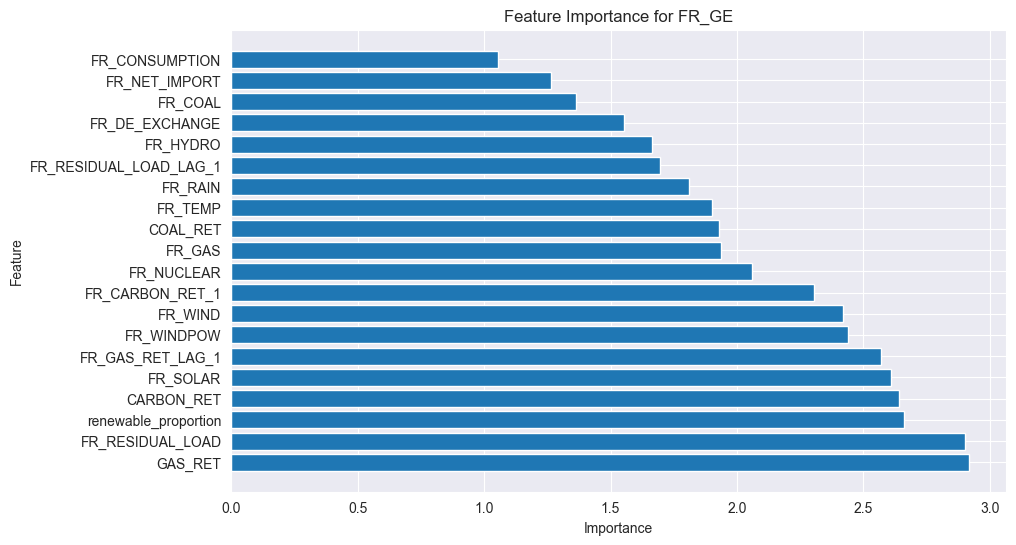

In [104]:
# Get feature importances
feature_importances = best_model_fr_ge.get_score(importance_type='gain')

# sort the feature importance
sorted_feature_importance = sorted(feature_importances.items(), key=lambda x: x[1], reverse=True)

features = [x[0] for x in sorted_feature_importance]
importances = [x[1] for x in sorted_feature_importance]

# Create the horizontal bar plot
plt.figure(figsize=(10, 6))
plt.barh(features, importances)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance for FR_GE')
plt.show()


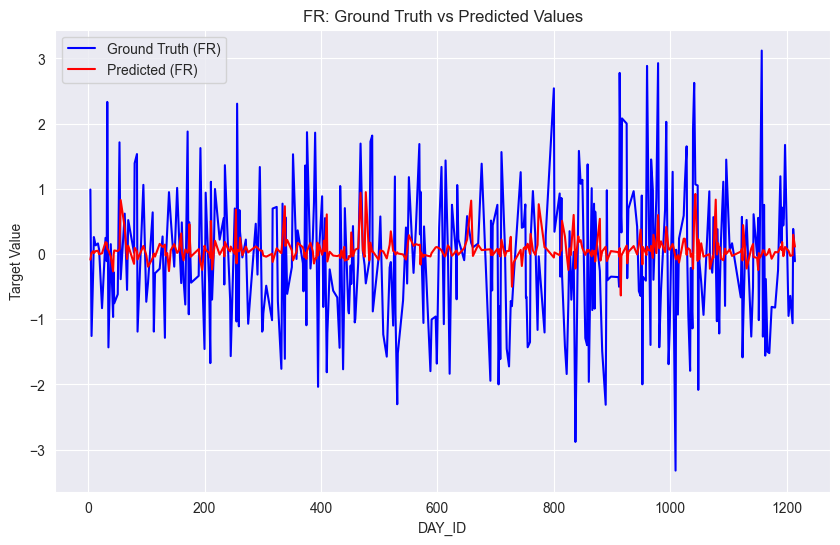

In [105]:
# Assuming Y_test_fr and predictions_fr are the target values for the FR model
# Assuming Y_test_de and predictions_de are the target values for the DE model

# Plot the ground truth and predicted values for the FR model
plt.figure(figsize=(10, 6))
plt.plot(X_test_fr['DAY_ID'], Y_test_fr['TARGET'], color='blue', label='Ground Truth (FR)')
plt.plot(X_test_fr['DAY_ID'], predictions_fr_ge, color='red', label='Predicted (FR)')
plt.xlabel('DAY_ID')
plt.ylabel('Target Value')
plt.title('FR: Ground Truth vs Predicted Values')
plt.legend()
plt.show()

In [106]:
print('Spearman correlation for the test set_fr: {:.1f}%'.format(100 * metric_train(predictions_fr_ge,Y_test_fr['TARGET'])))


Spearman correlation for the test set_fr: 6.2%


In [109]:
X_train_de_ge = X_train_de.drop(columns=["DAY_ID"])
X_train_de_ge['DE_RESIDUAL_LOAD_LAG_1'] = X_train_de['DE_RESIDUAL_LOAD'].shift(1)
X_train_de_ge['DE_GAS_RET_LAG_1'] = X_train_de['GAS_RET'].shift(1)
X_train_de_ge['DE_CARBON_RET_1'] = X_train_de['CARBON_RET'].shift(1)
X_train_de_ge["renewable_proportion"] = (X_train_de_ge["DE_COAL"]+X_train_de_ge["DE_GAS"]+X_train_de_ge["DE_LIGNITE"])/(
    X_train_de_ge["DE_COAL"]+X_train_de_ge["DE_GAS"]+X_train_de_ge["DE_HYDRO"]+X_train_de_ge["DE_NUCLEAR"]+X_train_de_ge["DE_SOLAR"]+
    X_train_de_ge["DE_WINDPOW"]
)

X_test_de_ge = X_test_de.drop(columns=["DAY_ID"])
X_test_de_ge['DE_RESIDUAL_LOAD_LAG_1'] = X_test_de_ge['DE_RESIDUAL_LOAD'].shift(1)
X_test_de_ge['DE_GAS_RET_LAG_1'] = X_test_de_ge['GAS_RET'].shift(1)
X_test_de_ge['DE_CARBON_RET_1'] = X_test_de_ge['CARBON_RET'].shift(1)
X_test_de_ge["renewable_proportion"] = (X_test_de_ge["DE_COAL"]+X_test_de_ge["DE_GAS"]+X_test_de_ge["DE_LIGNITE"])/(
    X_test_de_ge["DE_COAL"]+X_test_de_ge["DE_GAS"]+X_test_de_ge["DE_HYDRO"]+X_test_de_ge["DE_NUCLEAR"]+X_test_de_ge["DE_SOLAR"]+
    X_test_de_ge["DE_WINDPOW"]
)


In [110]:

dtrain_de_ge = xgb.DMatrix(X_train_de_ge, label=Y_train_de['TARGET'])
dtest_de_ge = xgb.DMatrix(X_test_de_ge, label=Y_test_de['TARGET'])

def objective(trial):
    # Define search space for hyperparameters
    params = {
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'max_depth': trial.suggest_int('max_depth', 6, 20),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.8,log=True),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'n_estimators': trial.suggest_float('n_estimators',100,300),
        'verbosity': 0
    }
    
    # Train XGBoost model
    model = xgb.train(params, dtrain_de_ge, num_boost_round=100)
    
    # Make predictions on the test set
    predictions = model.predict(dtest_de_ge)
    
    # Calculate RMSE
    rmse = root_mean_squared_error(Y_test_de['TARGET'], predictions)
    
    return rmse

# Create study object and optimize parameters
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

# Get the best parameters
best_params_de_ge = study.best_params
print("Best Parameters for FR:", best_params_de_ge)

# Train XGBoost model with best parameters for FR
best_model_de_ge = xgb.train(best_params_de_ge, dtrain_de_ge, num_boost_round=100)

# Make predictions on the test set for FR
predictions_de_ge = best_model_de_ge.predict(dtest_de_ge)

# Calculate RMSE for FR
rmse_de_ge = root_mean_squared_error(Y_test_de['TARGET'], predictions_de_ge)
print(f"Root Mean Squared Error For FR: {rmse_de_ge:.2f}")


[I 2024-03-04 12:44:41,593] A new study created in memory with name: no-name-befbc856-8927-4986-8e03-170806f4fef1
[I 2024-03-04 12:44:42,010] Trial 0 finished with value: 1.0864266231743387 and parameters: {'max_depth': 19, 'learning_rate': 0.14849183351677292, 'subsample': 0.9200931823990107, 'colsample_bytree': 0.6961605149796097, 'n_estimators': 234.91614018859534}. Best is trial 0 with value: 1.0864266231743387.
[I 2024-03-04 12:44:42,099] Trial 1 finished with value: 1.13905773848548 and parameters: {'max_depth': 8, 'learning_rate': 0.5181248388705896, 'subsample': 0.9271792550144382, 'colsample_bytree': 0.7719497863636158, 'n_estimators': 139.5375593277917}. Best is trial 0 with value: 1.0864266231743387.
[I 2024-03-04 12:44:42,180] Trial 2 finished with value: 1.1887245343345192 and parameters: {'max_depth': 9, 'learning_rate': 0.6716627555980599, 'subsample': 0.9900814656956447, 'colsample_bytree': 0.9480189397696193, 'n_estimators': 229.57153434184704}. Best is trial 0 with va

Best Parameters for FR: {'max_depth': 17, 'learning_rate': 0.010116078932963344, 'subsample': 0.9659546498481151, 'colsample_bytree': 0.8927470918035728, 'n_estimators': 232.9426876335952}
Root Mean Squared Error For FR: 1.00


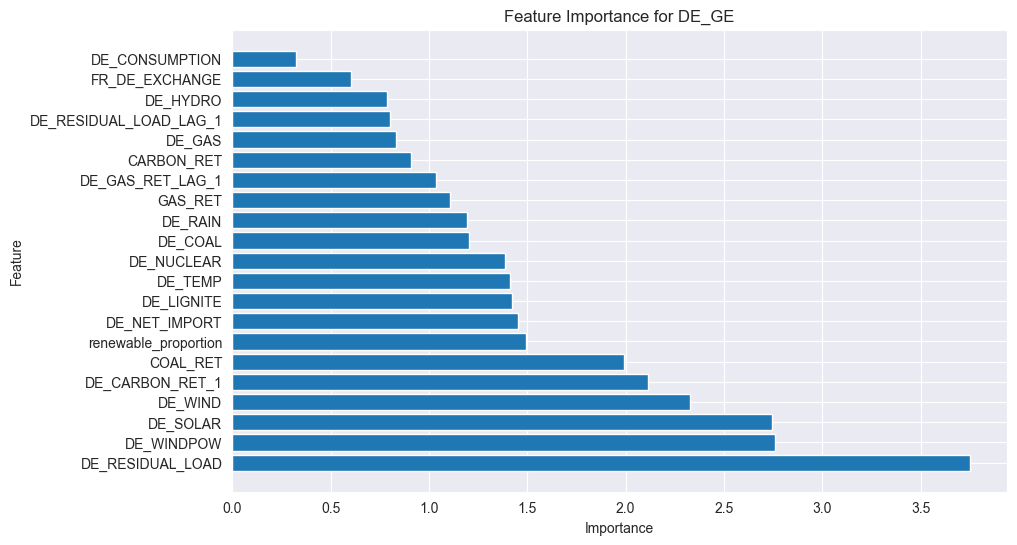

In [111]:
# Get feature importances
feature_importances = best_model_de_ge.get_score(importance_type='gain')

# sort the feature importance
sorted_feature_importance = sorted(feature_importances.items(), key=lambda x: x[1], reverse=True)

features = [x[0] for x in sorted_feature_importance]
importances = [x[1] for x in sorted_feature_importance]

# Create the horizontal bar plot
plt.figure(figsize=(10, 6))
plt.barh(features, importances)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance for DE_GE')
plt.show()


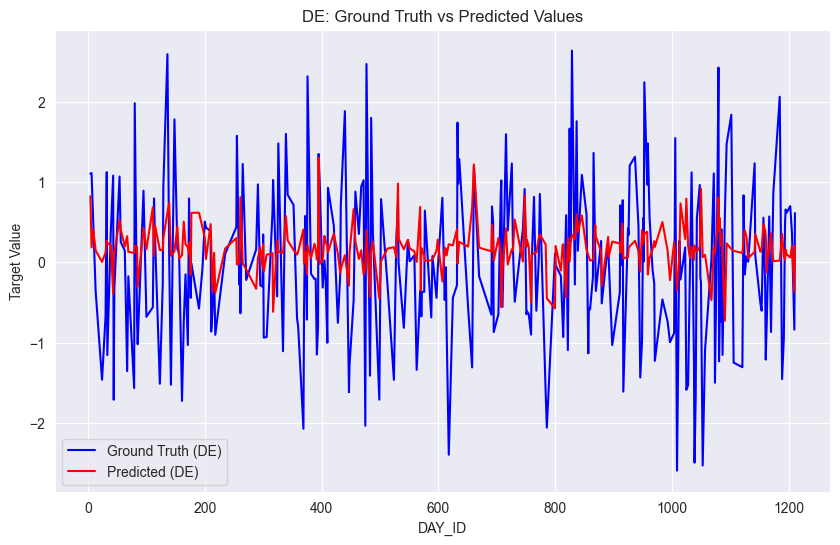

In [112]:
# Assuming Y_test_fr and predictions_fr are the target values for the FR model
# Assuming Y_test_de and predictions_de are the target values for the DE model

# Plot the ground truth and predicted values for the FR model
plt.figure(figsize=(10, 6))
plt.plot(X_test_de['DAY_ID'], Y_test_de['TARGET'], color='blue', label='Ground Truth (DE)')
plt.plot(X_test_de['DAY_ID'], predictions_de_ge, color='red', label='Predicted (DE)')
plt.xlabel('DAY_ID')
plt.ylabel('Target Value')
plt.title('DE: Ground Truth vs Predicted Values')
plt.legend()
plt.show()

In [113]:
print('Spearman correlation for the test set_de: {:.1f}%'.format(100 * metric_train(predictions_de_ge,Y_test_de['TARGET'])))

predictions_ge = np.concatenate([predictions_fr_ge, predictions_de_ge],axis=0)
groundtruth = pd.concat([Y_test_fr['TARGET'],Y_test_de['TARGET']],axis=0)
print('Spearman correlation for the test set: {:.1f}%'.format(100 * metric_train(predictions_ge,groundtruth)))


Spearman correlation for the test set_de: 13.6%
Spearman correlation for the test set: 10.1%


In [115]:
X_test_fr_sub = fr_test_df[["ID"]]
X_test_de_sub = de_test_df[["ID"]]

Y_test_submission_fr_ge = X_test_fr_sub[['ID']].copy()
Y_test_submission_fr_ge['TARGET'] = predictions_fr_ge
Y_test_submission_de_ge = X_test_de_sub[['ID']].copy()
Y_test_submission_de_ge['TARGET'] = predictions_de_ge
Y_test_submission = pd.concat([Y_test_submission_fr_ge, Y_test_submission_de_ge], ignore_index=True)

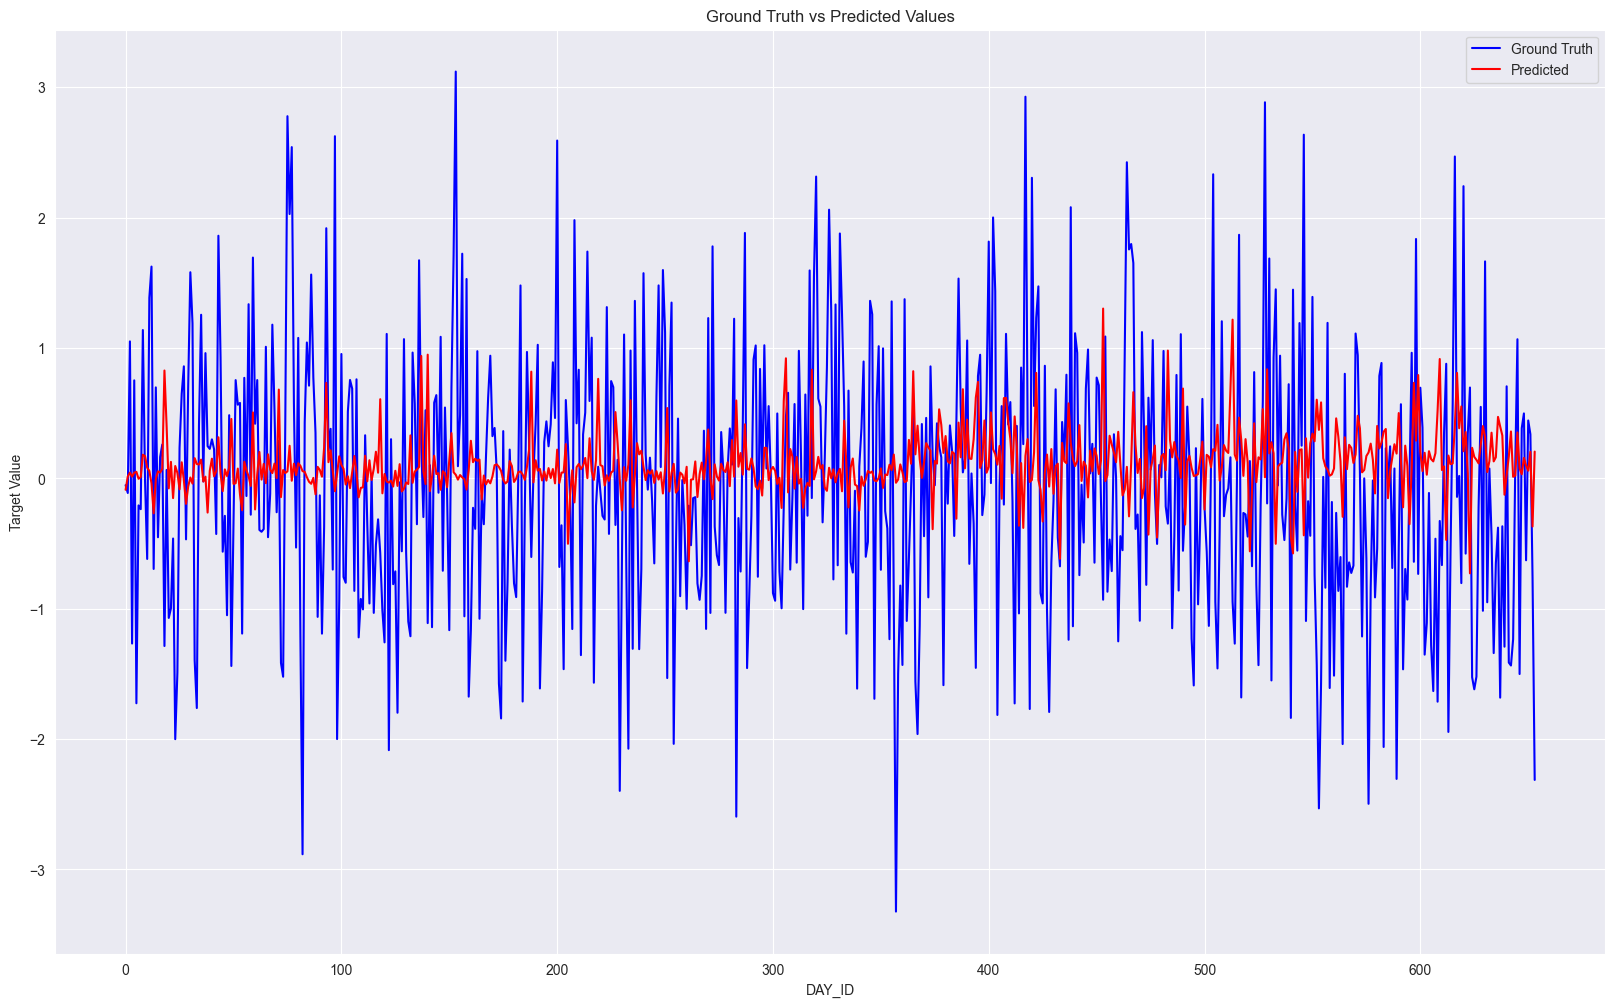

In [116]:
# Plot the ground truth and predicted values for the FR model
plt.figure(figsize=(20, 12))
plt.plot(Y_test['TARGET'], color='blue', label='Ground Truth')
plt.plot(Y_test_submission['TARGET'], color='red', label='Predicted')
plt.xlabel('DAY_ID')
plt.ylabel('Target Value')
plt.title('Ground Truth vs Predicted Values')
plt.legend()
plt.show()